In [19]:
import random 
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

class BatAlgorithm2():
    def __init__(self, D, NP, A, r, Qmin, Qmax, Lower, Upper, function):
        self.D = D  #dimension 
        self.NP = NP  #population size
        self.A = A  #loudness
        self.r = r  #pulse rate
        self.Qmin = Qmin  #frequency min
        self.Qmax = Qmax  #frequency max
        self.Lower = Lower  #lower bound
        self.Upper = Upper  #upper bound
        self.f_min = 0.0  #minimum fitness      
        self.Lb = [0] * self.D  #lower bound
        self.Ub = [0] * self.D  #upper bound
        self.Q = [0] * self.NP  #frequency

        self.v = [[0 for i in range(self.D)] for j in range(self.NP)]  #velocity
        self.delta = [[0 for i in range(self.D)] for j in range(self.NP)]  #velocity new (Added !!!!)
        self.Sol = [[0 for i in range(self.D)] for j in range(self.NP)]  #population of solutions
        self.Fitness = [0] * self.NP  #fitness
        self.best = [0] * self.D  #best solution
        self.Fun = function

    def best_bat(self):
        i = 0
        j = 0
        for i in range(self.NP):
            if self.Fitness[i] < self.Fitness[j]:
                j = i
        for i in range(self.D):
            self.best[i] = self.Sol[j][i]
        self.f_min = self.Fitness[j]

    def init_bat(self):
        for i in range(self.D):
            self.Lb[i] = self.Lower
            self.Ub[i] = self.Upper

        for i in range(self.NP):
            self.Q[i] = 0
            for j in range(self.D):
                rnd = np.random.uniform(0, 1)
                self.v[i][j] = 0.0
                self.Sol[i][j] = self.Lb[j] + (self.Ub[j] - self.Lb[j]) * rnd
            self.Fitness[i] = self.Fun(np.array(self.Sol[i]))
        self.best_bat()

    def simplebounds(self, val, lower, upper):
        if val < lower:
            val = lower
        if val > upper:
            val = upper
        return val

    def move_bat(self):
        t = 0 #iteration number
        stop_flag = 0 
        S = [[0.0 for i in range(self.D)] for j in range(self.NP)]        
        hist = [] #history
        self.init_bat()

        while ((stop_flag < 20) and (t<1500)):
#         while (t<300):
            for i in range(self.NP):
                beta = np.random.uniform(0, 1)
                sigma = np.random.uniform(0, 1)
                self.Q[i] = self.Qmin + (self.Qmax - self.Qmin) * beta
                
                for j in range(self.D):
                    self.v[i][j] = self.v[i][j] + (self.Sol[i][j] -
                                                   self.best[j]) * self.Q[i]
                    self.delta[i][j] = self.v[i][j] + (0.343 + 0.61*20*(-1+2*sigma))*0.5
#                     self.delta[i][j] = self.v[i][j]
                    S[i][j] = self.Sol[i][j] + self.delta[i][j]                                             
                    S[i][j] = self.simplebounds(S[i][j], self.Lb[j],
                                                self.Ub[j])

                rnd = np.random.random_sample()
                if rnd > self.r:
                    for j in range(self.D):
                        S[i][j] = self.best[j] + 0.001 * random.gauss(0, 1)
                        S[i][j] = self.simplebounds(S[i][j], self.Lb[j],
                                                self.Ub[j])
                        
                Fnew = self.Fun(np.array(S[i]))
                rnd = np.random.random_sample()
                
                if (Fnew <= self.Fitness[i]) and (rnd < self.A):
                    for j in range(self.D):
                        self.Sol[i][j] = S[i][j]
                    self.Fitness[i] = Fnew
               
                if Fnew <= self.f_min:
                    for j in range(self.D):
                        self.best[j] = S[i][j]
                    self.f_min = Fnew
                solution = [self.f_min, np.array(self.best)]

            if t>20:
#                 k=np.abs(hist[-1] - self.f_min)
                k=np.abs(hist[-1] - hist[-21])
                if (k) <= 10**(-3):
                    stop_flag += 1
                else:
                    stop_flag = 0
                    
            t += 1
            hist.append(solution[0])
        return solution, hist, t

In [20]:
def sphere(x):
    return np.sum(x ** 2)

def Rastrigin(x):
    fn = 0
    for i in range(len(x)):
        fn = fn + x[i]**2 - 10 * np.cos(2 * np.pi * x[i])
    return fn + 10 * len(x)

def Rosenbrok(x):
    ans = 0
    for i in range(len(x) - 1):
        ans += 100 * (x[i]**2 - x[i + 1])**2 + (x[i] - 1)**2
    return ans

In [32]:
DIMENSION_X = [2, 4, 8, 16, 32]
MULTISTART = 100
OKRESTNOST = 0.01

def results2(FUNC):
    if FUNC == sphere:
        FUNC_OPT_F = 0
        A = 5
        
    if FUNC == Rastrigin:
        FUNC_OPT_F = 0
        A = 5

    if FUNC == Rosenbrok:
        FUNC_OPT_F = 0 #390
        A = 5 #100

    f_accuracy_all = []
    x_accuracy_all = []
    history_all = []
    step_min_all = []
    y0 = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []

    print(f'Function: {FUNC.__name__}')
    print('Dim\t| best f\t| best x\t| mean f\t| mean x\t| probability')

    for DIM_X in DIMENSION_X:    
        
        if FUNC == sphere or FUNC == Rastrigin:
            FUNC_OPT_X = np.zeros(DIM_X)
        if FUNC == Rosenbrok:
            FUNC_OPT_X = np.ones(DIM_X)

        f_accuracy_dim = []
        f_best_dim = []
        x_accuracy_dim = []
        okr_prob = []
        step_min_arr = []
        hist_arr = []

        for start_num in range(MULTISTART):
            BA = BatAlgorithm2(DIM_X, 100, 0.5, 0.5, 0.0, 2.0, -A, A, FUNC)
            best, hist, step_min = BA.move_bat()
            f_accuracy_dim.append(abs(best[0] - FUNC_OPT_F))
            x_accuracy_dim.append(np.linalg.norm(best[1] - FUNC_OPT_X))

            if abs(best[0] - FUNC_OPT_F) < OKRESTNOST:
#             if np.linalg.norm(best[1] - FUNC_OPT_X) < OKRESTNOST:
                okr_prob.append(1)
            else:
                okr_prob.append(0)
                
            step_min_arr.append(step_min)
            hist_arr.append(hist)

        f_accuracy_all.append(f_accuracy_dim)
        x_accuracy_all.append(x_accuracy_dim)
        print('min_step=',min(step_min_arr))
        history_all.append(hist_arr[np.argmin(step_min_arr)])
        
        min_f = min(f_accuracy_dim)
        min_x = min(x_accuracy_dim)
        mean_f = sum(f_accuracy_dim) / len(f_accuracy_dim)
        mean_x = sum(x_accuracy_dim) / len(x_accuracy_dim)
        prob = sum(okr_prob) / len(okr_prob)
        print(f"{DIM_X}\t| {'{0:.1e}'.format(min_f)}\t| {'{0:.1e}'.format(min_x)}\t| {'{0:.1e}'.format(mean_f)}\t| {'{0:.1e}'.format(mean_x)}\t| {'{0:.1e}'.format(prob)}")
        y0.append(min_f)
        y1.append(min_x)
        y2.append(mean_f)
        y3.append(mean_x)
        y4.append(prob)

    fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10, 15), dpi=400)
    axs[0].scatter(x=DIMENSION_X, y=y0, label="Best f", color='b')
    axs[0].plot(DIMENSION_X, y0, color='b', linewidth=1.5)
    axs[0].set_ylabel('Лучшее\n |$f^{opt}-f^*$|')
    axs[0].minorticks_on()
    axs[0].grid(which='major')
    axs[0].grid(which='minor', linestyle=':')
    if FUNC == sphere:
        axs[0].set_yscale('log')

    axs[1].scatter(x=DIMENSION_X, y=y1, label="Best x", color='b')
    axs[1].plot(DIMENSION_X, y1, color='b', linewidth=1.5)
    axs[1].set_ylabel('Лучшее\n $||x^{opt}-x^*||_E$')
    axs[1].minorticks_on()
    axs[1].grid(which='major')
    axs[1].grid(which='minor', linestyle=':')
    if FUNC == sphere:
        axs[1].set_yscale('log')

    axs[2].scatter(x=DIMENSION_X, y=y2, label="mean f", color='b')
    axs[2].plot(DIMENSION_X, y2, color='b', linewidth=1.5)
    axs[2].set_ylabel('Среднее\n |$f^{opt}-f^*$|')
    axs[2].minorticks_on()
    axs[2].grid(which='major')
    axs[2].grid(which='minor', linestyle=':')
    if FUNC == sphere:
        axs[2].set_yscale('log')

    axs[3].scatter(x=DIMENSION_X, y=y3, label="mean x", color='b')
    axs[3].plot(DIMENSION_X, y3, color='b', linewidth=1.5)
    axs[3].set_ylabel('Среднее\n $||x^{opt}-x^*||_E$')
    axs[3].minorticks_on()
    axs[3].grid(which='major')
    axs[3].grid(which='minor', linestyle=':')
    if FUNC == sphere:
        axs[3].set_yscale('log')

    axs[4].scatter(x=DIMENSION_X, y=y4, label="prob", color='b')
    axs[4].plot(DIMENSION_X, y4, color='b', linewidth=1.5)
    axs[4].set_ylabel('Вероятость\n попадания\n в $ε_X$')
    axs[4].minorticks_on()
    axs[4].grid(which='major')
    axs[4].grid(which='minor', linestyle=':')

    plt.xlabel("|X|")
    plt.show()
    
    return(history_all)

In [22]:
def iter_graph(y,n):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 15), dpi=400)
    for i in range(len(y)):
        axs[i].plot(y[i], color='b', linewidth=1.5)
        axs[i].set_title(f'|X|={DIMENSION_X[i]}')
        axs[i].set_ylabel(f'$f_{n}$')
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i].grid()

    plt.subplots_adjust(wspace=0, hspace=0.3)
    plt.xlabel("Номер итерации")
    plt.show()

In [23]:
def iter_graph2(y,n):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=400)
    style = ['--','-','-.',':','solid']
    for i in range(len(y)):
        axs.plot(y[i], linewidth=2, linestyle = style[i], label= f'$f_{n}при|X|={DIMENSION_X[i]}$')
    axs.set_ylabel(f'$f_{n}$')
    axs.grid()
    axs.legend()
    plt.xlabel("Номер итерации")
    plt.show()

Function: sphere
Dim	| best f	| best x	| mean f	| mean x	| probability
min_step= 41
2	| 2.9e-12	| 1.7e-06	| 7.0e-10	| 2.4e-05	| 1.0e+00
min_step= 49
4	| 6.2e-09	| 7.9e-05	| 4.8e-08	| 2.1e-04	| 1.0e+00
min_step= 106
8	| 1.9e-07	| 4.4e-04	| 6.5e-07	| 8.0e-04	| 1.0e+00
min_step= 159
16	| 2.5e-06	| 1.6e-03	| 4.6e-06	| 2.1e-03	| 1.0e+00
min_step= 281
32	| 1.1e-05	| 3.3e-03	| 2.4e-05	| 4.9e-03	| 1.0e+00


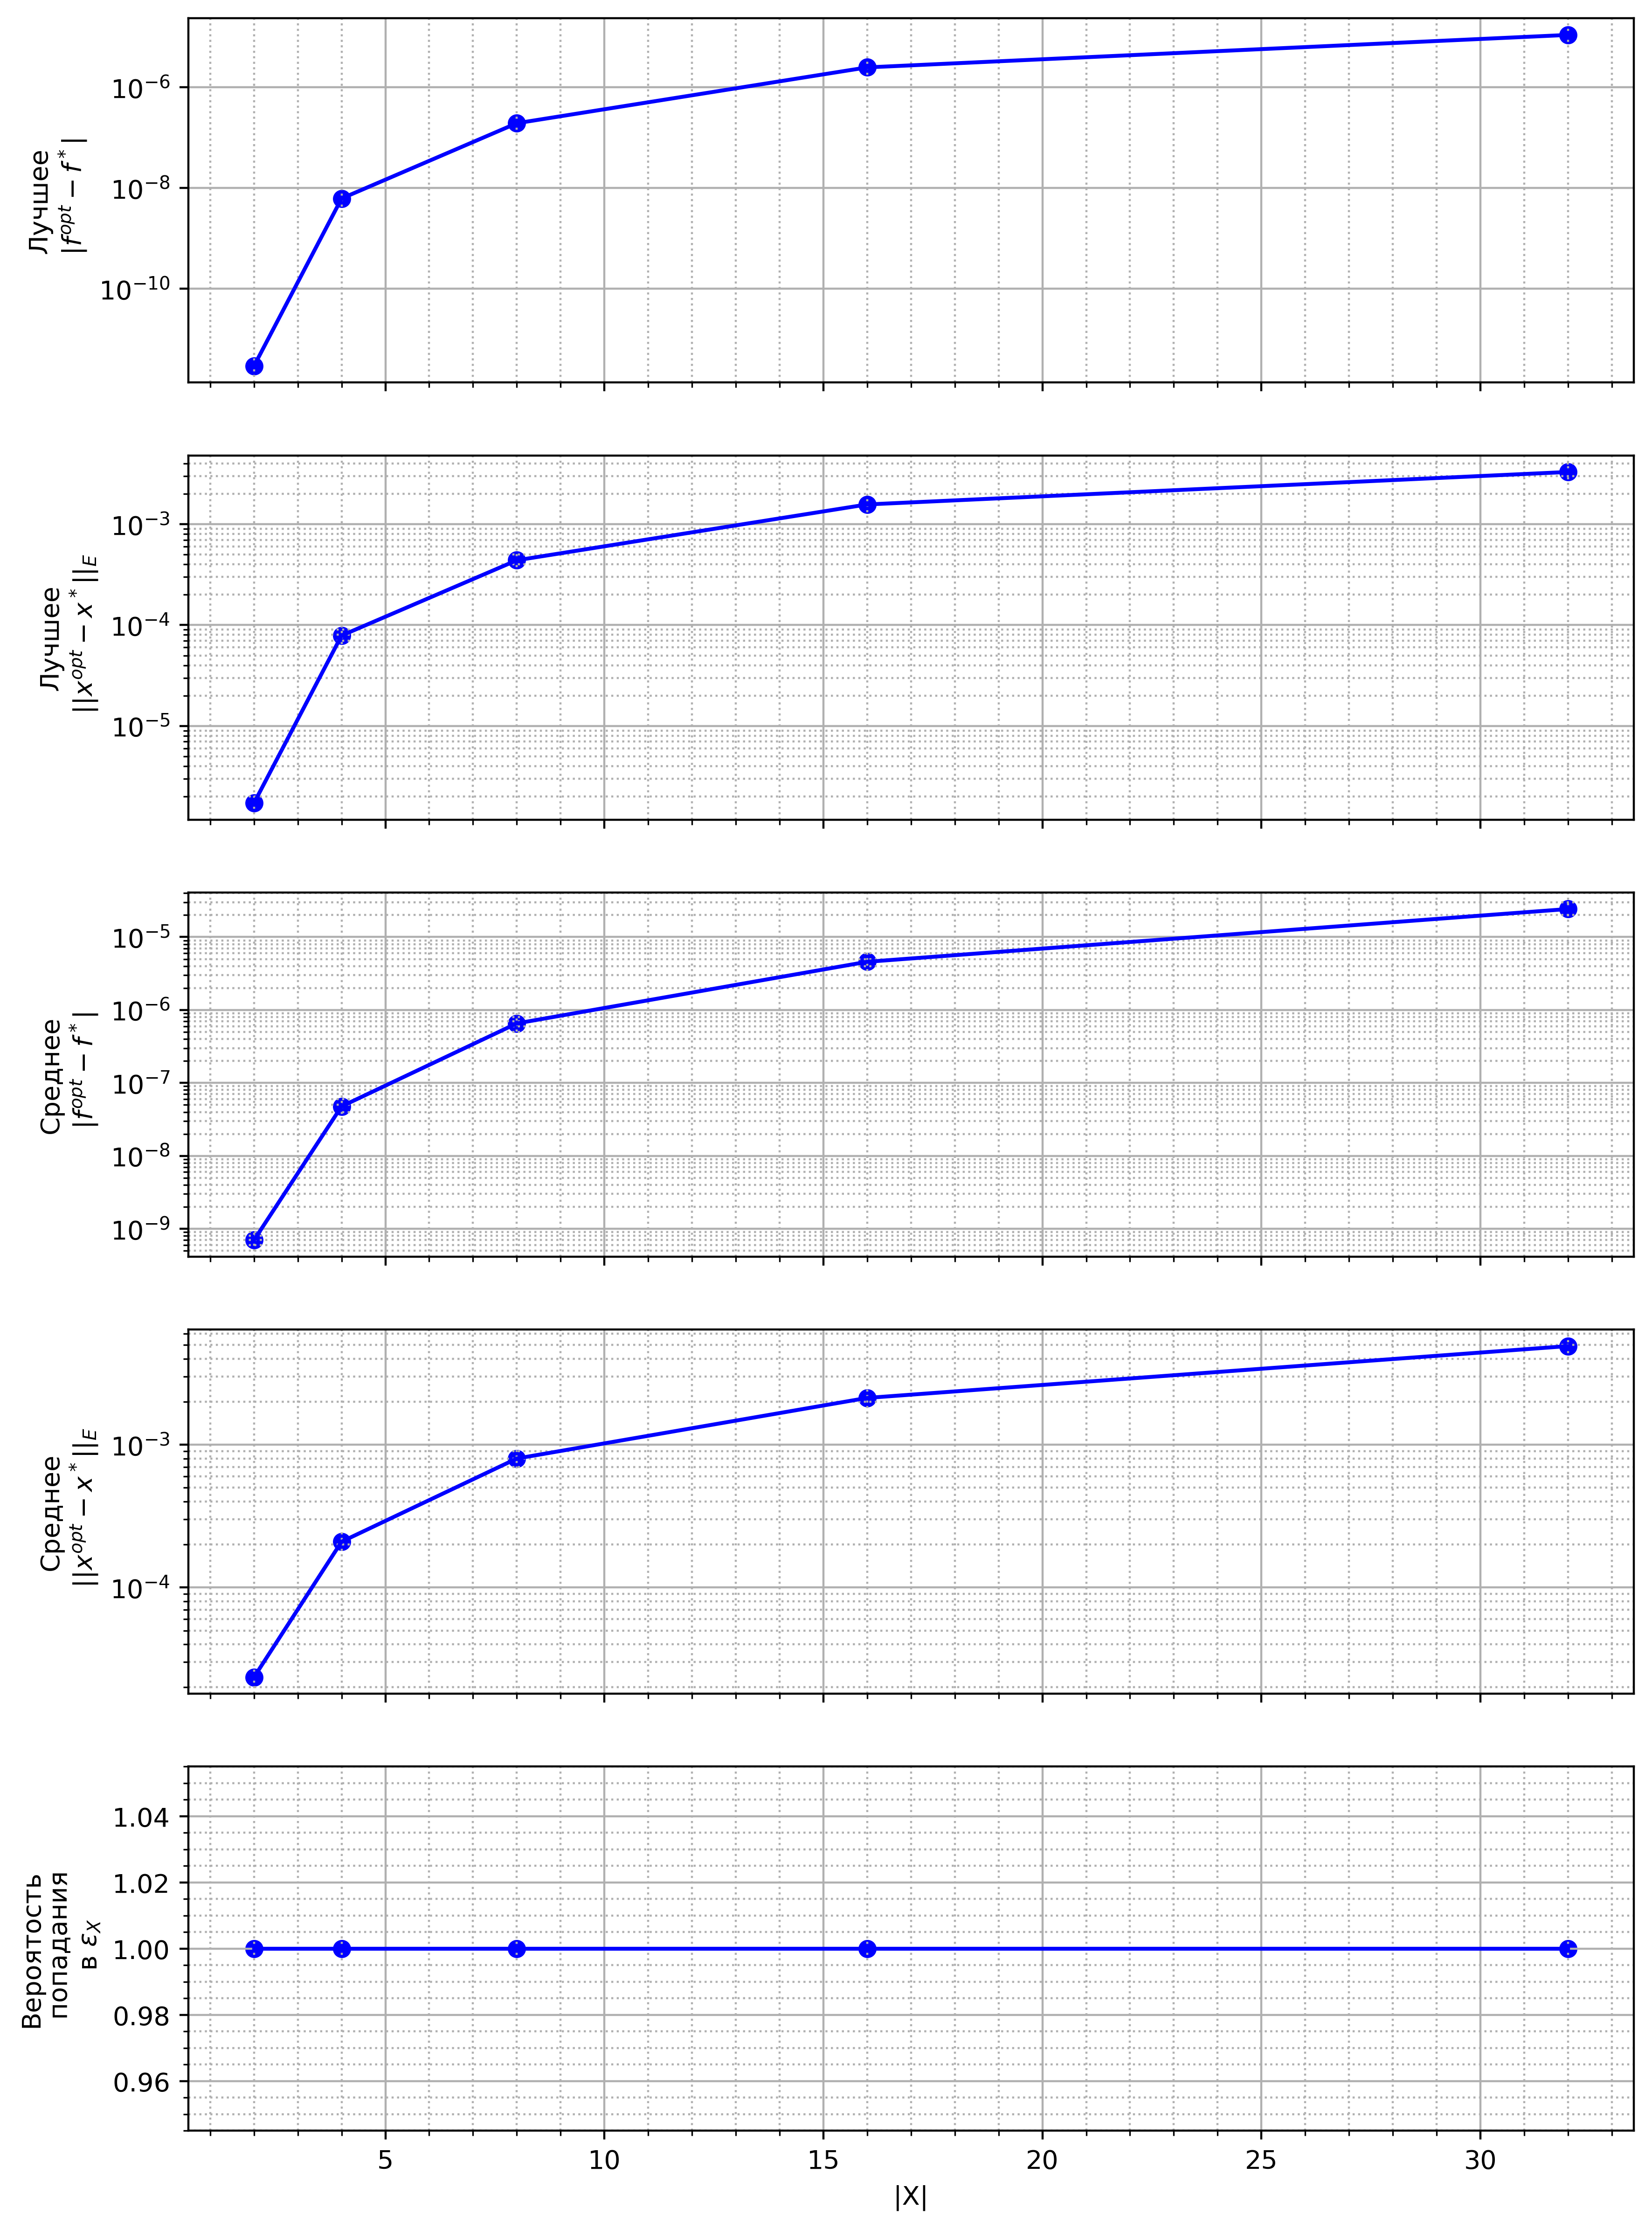

In [24]:
hist_sphere=results2(sphere)

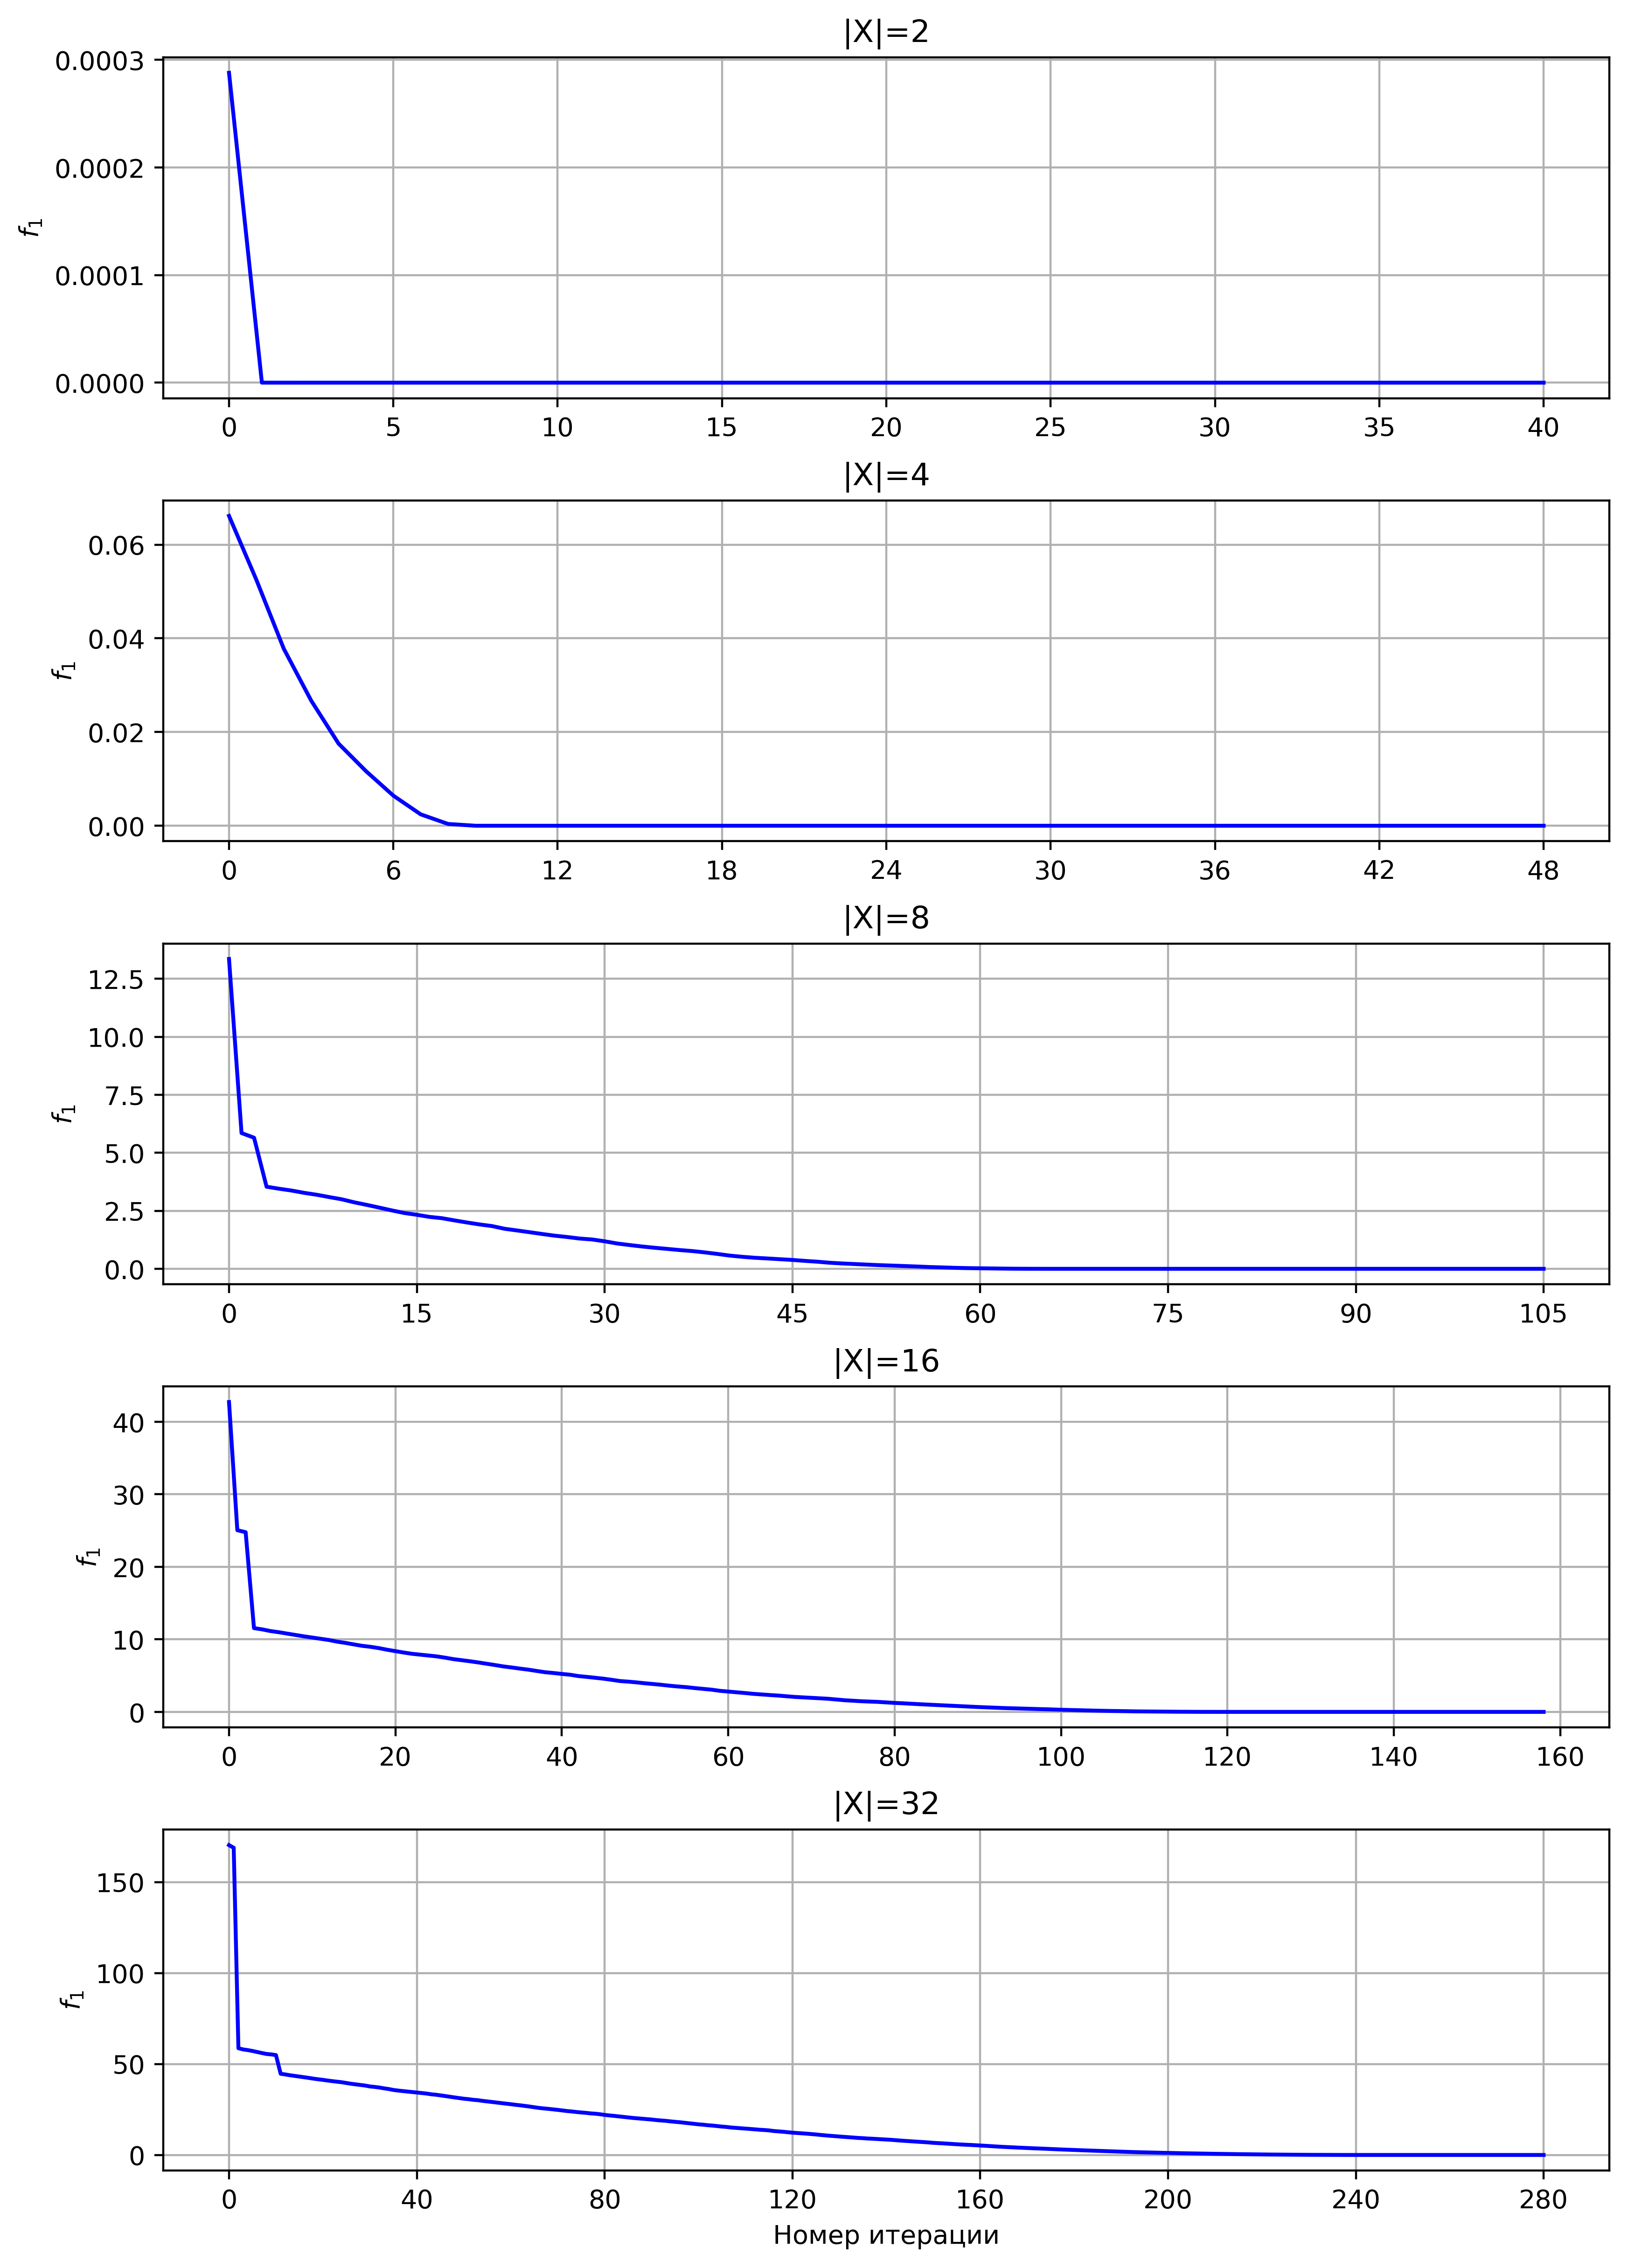

In [25]:
iter_graph(hist_sphere,1)

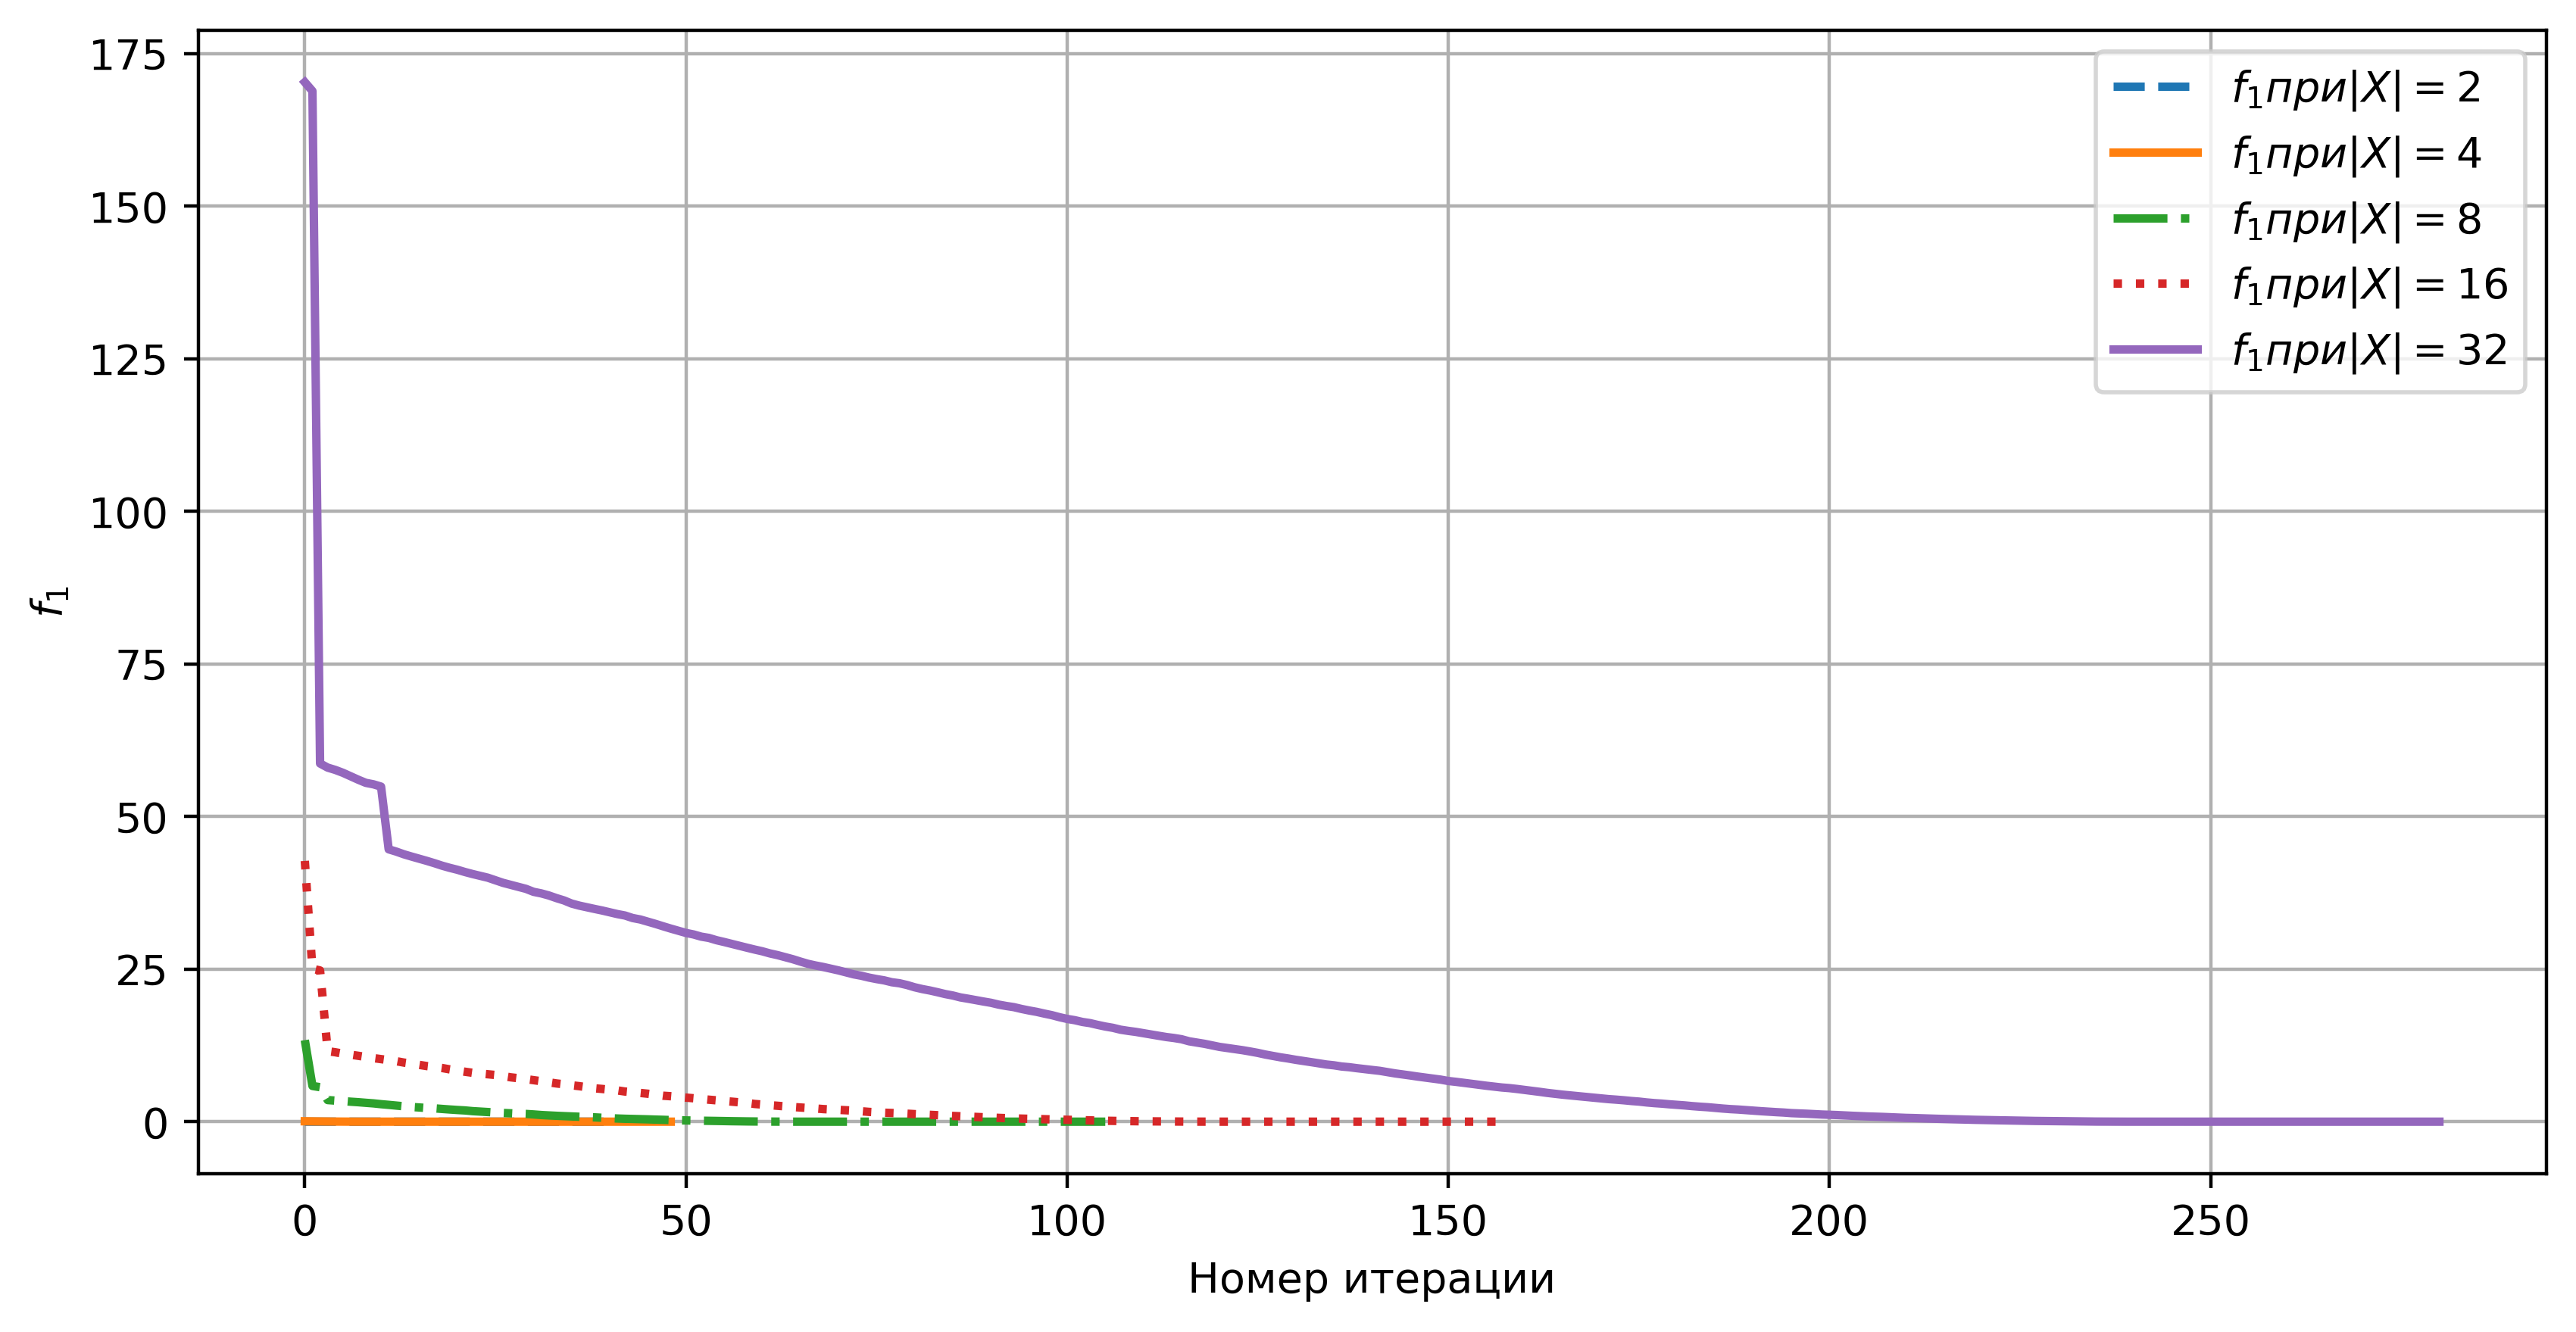

In [26]:
iter_graph2(hist_sphere,1)

Function: Rastrigin
Dim	| best f	| best x	| mean f	| mean x	| probability
min_step= 41
2	| 1.1e-08	| 7.3e-06	| 9.7e-01	| 8.2e-01	| 2.8e-01
min_step= 45
4	| 9.9e-01	| 9.9e-01	| 7.9e+00	| 2.7e+00	| 0.0e+00
min_step= 50
8	| 7.0e+00	| 2.6e+00	| 2.6e+01	| 5.0e+00	| 0.0e+00
min_step= 63
16	| 2.2e+01	| 4.7e+00	| 6.5e+01	| 7.9e+00	| 0.0e+00
min_step= 94
32	| 5.1e+01	| 7.1e+00	| 1.4e+02	| 1.2e+01	| 0.0e+00


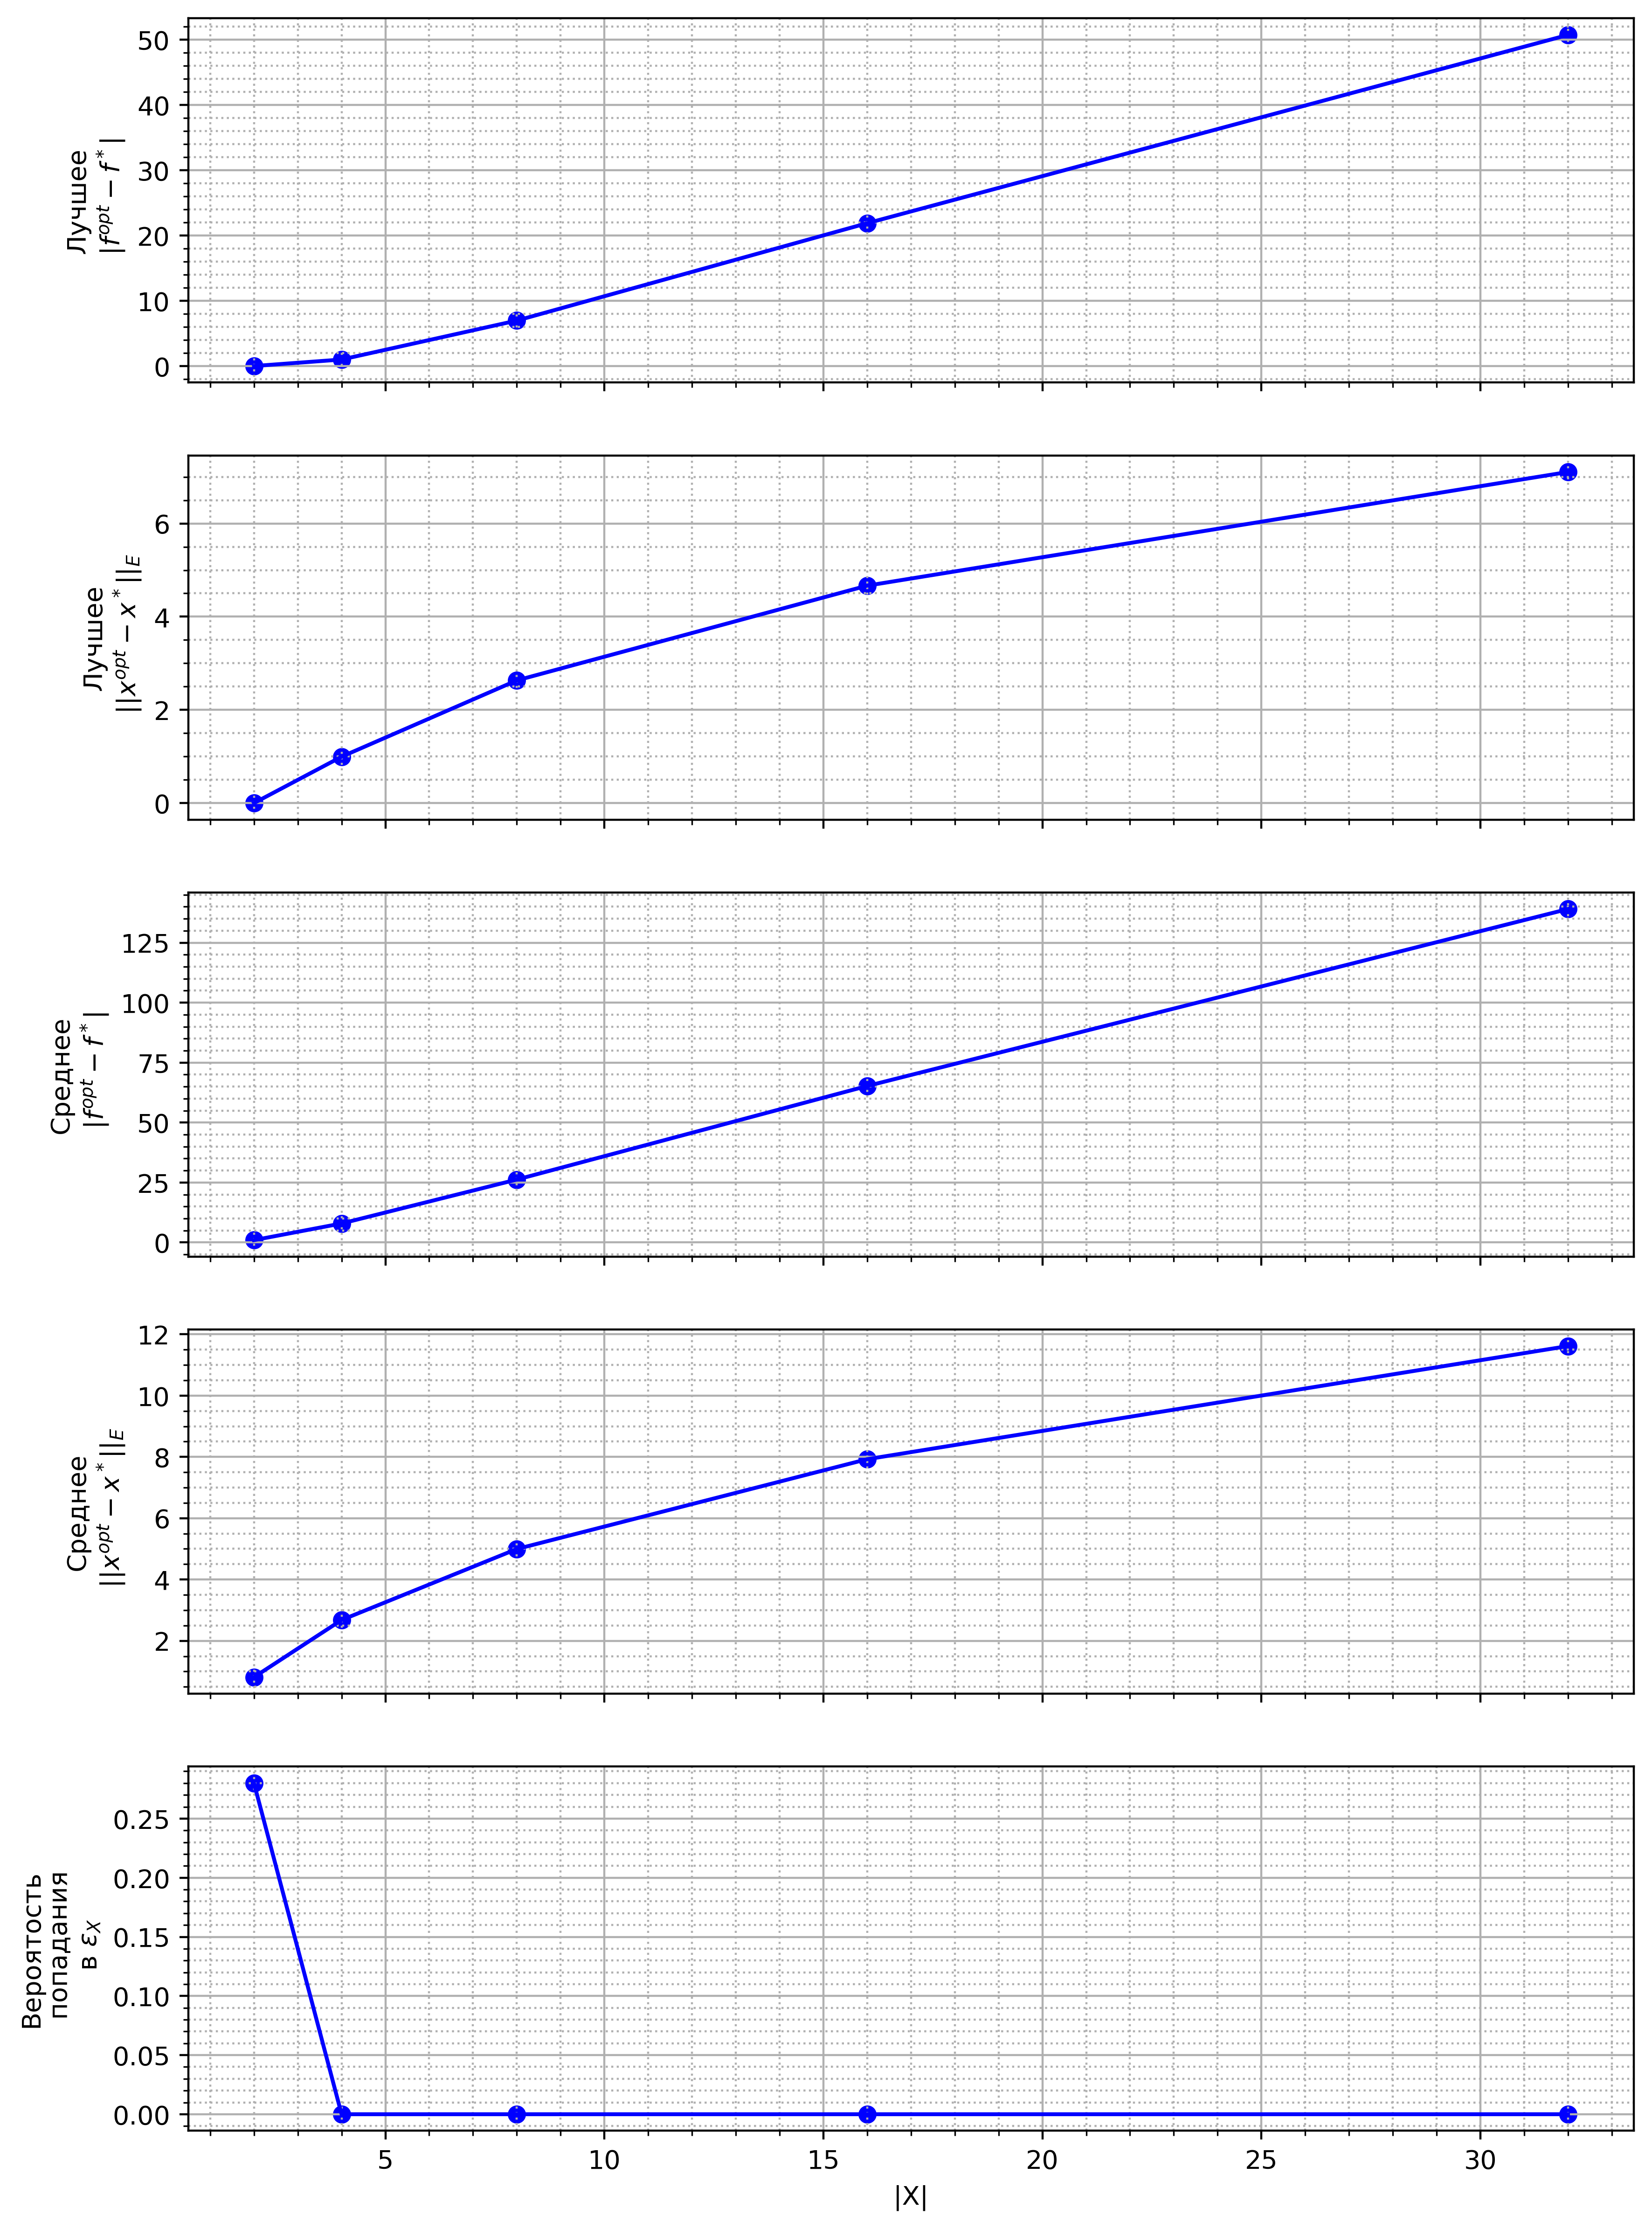

In [27]:
hist_Rastrigin=results2(Rastrigin)

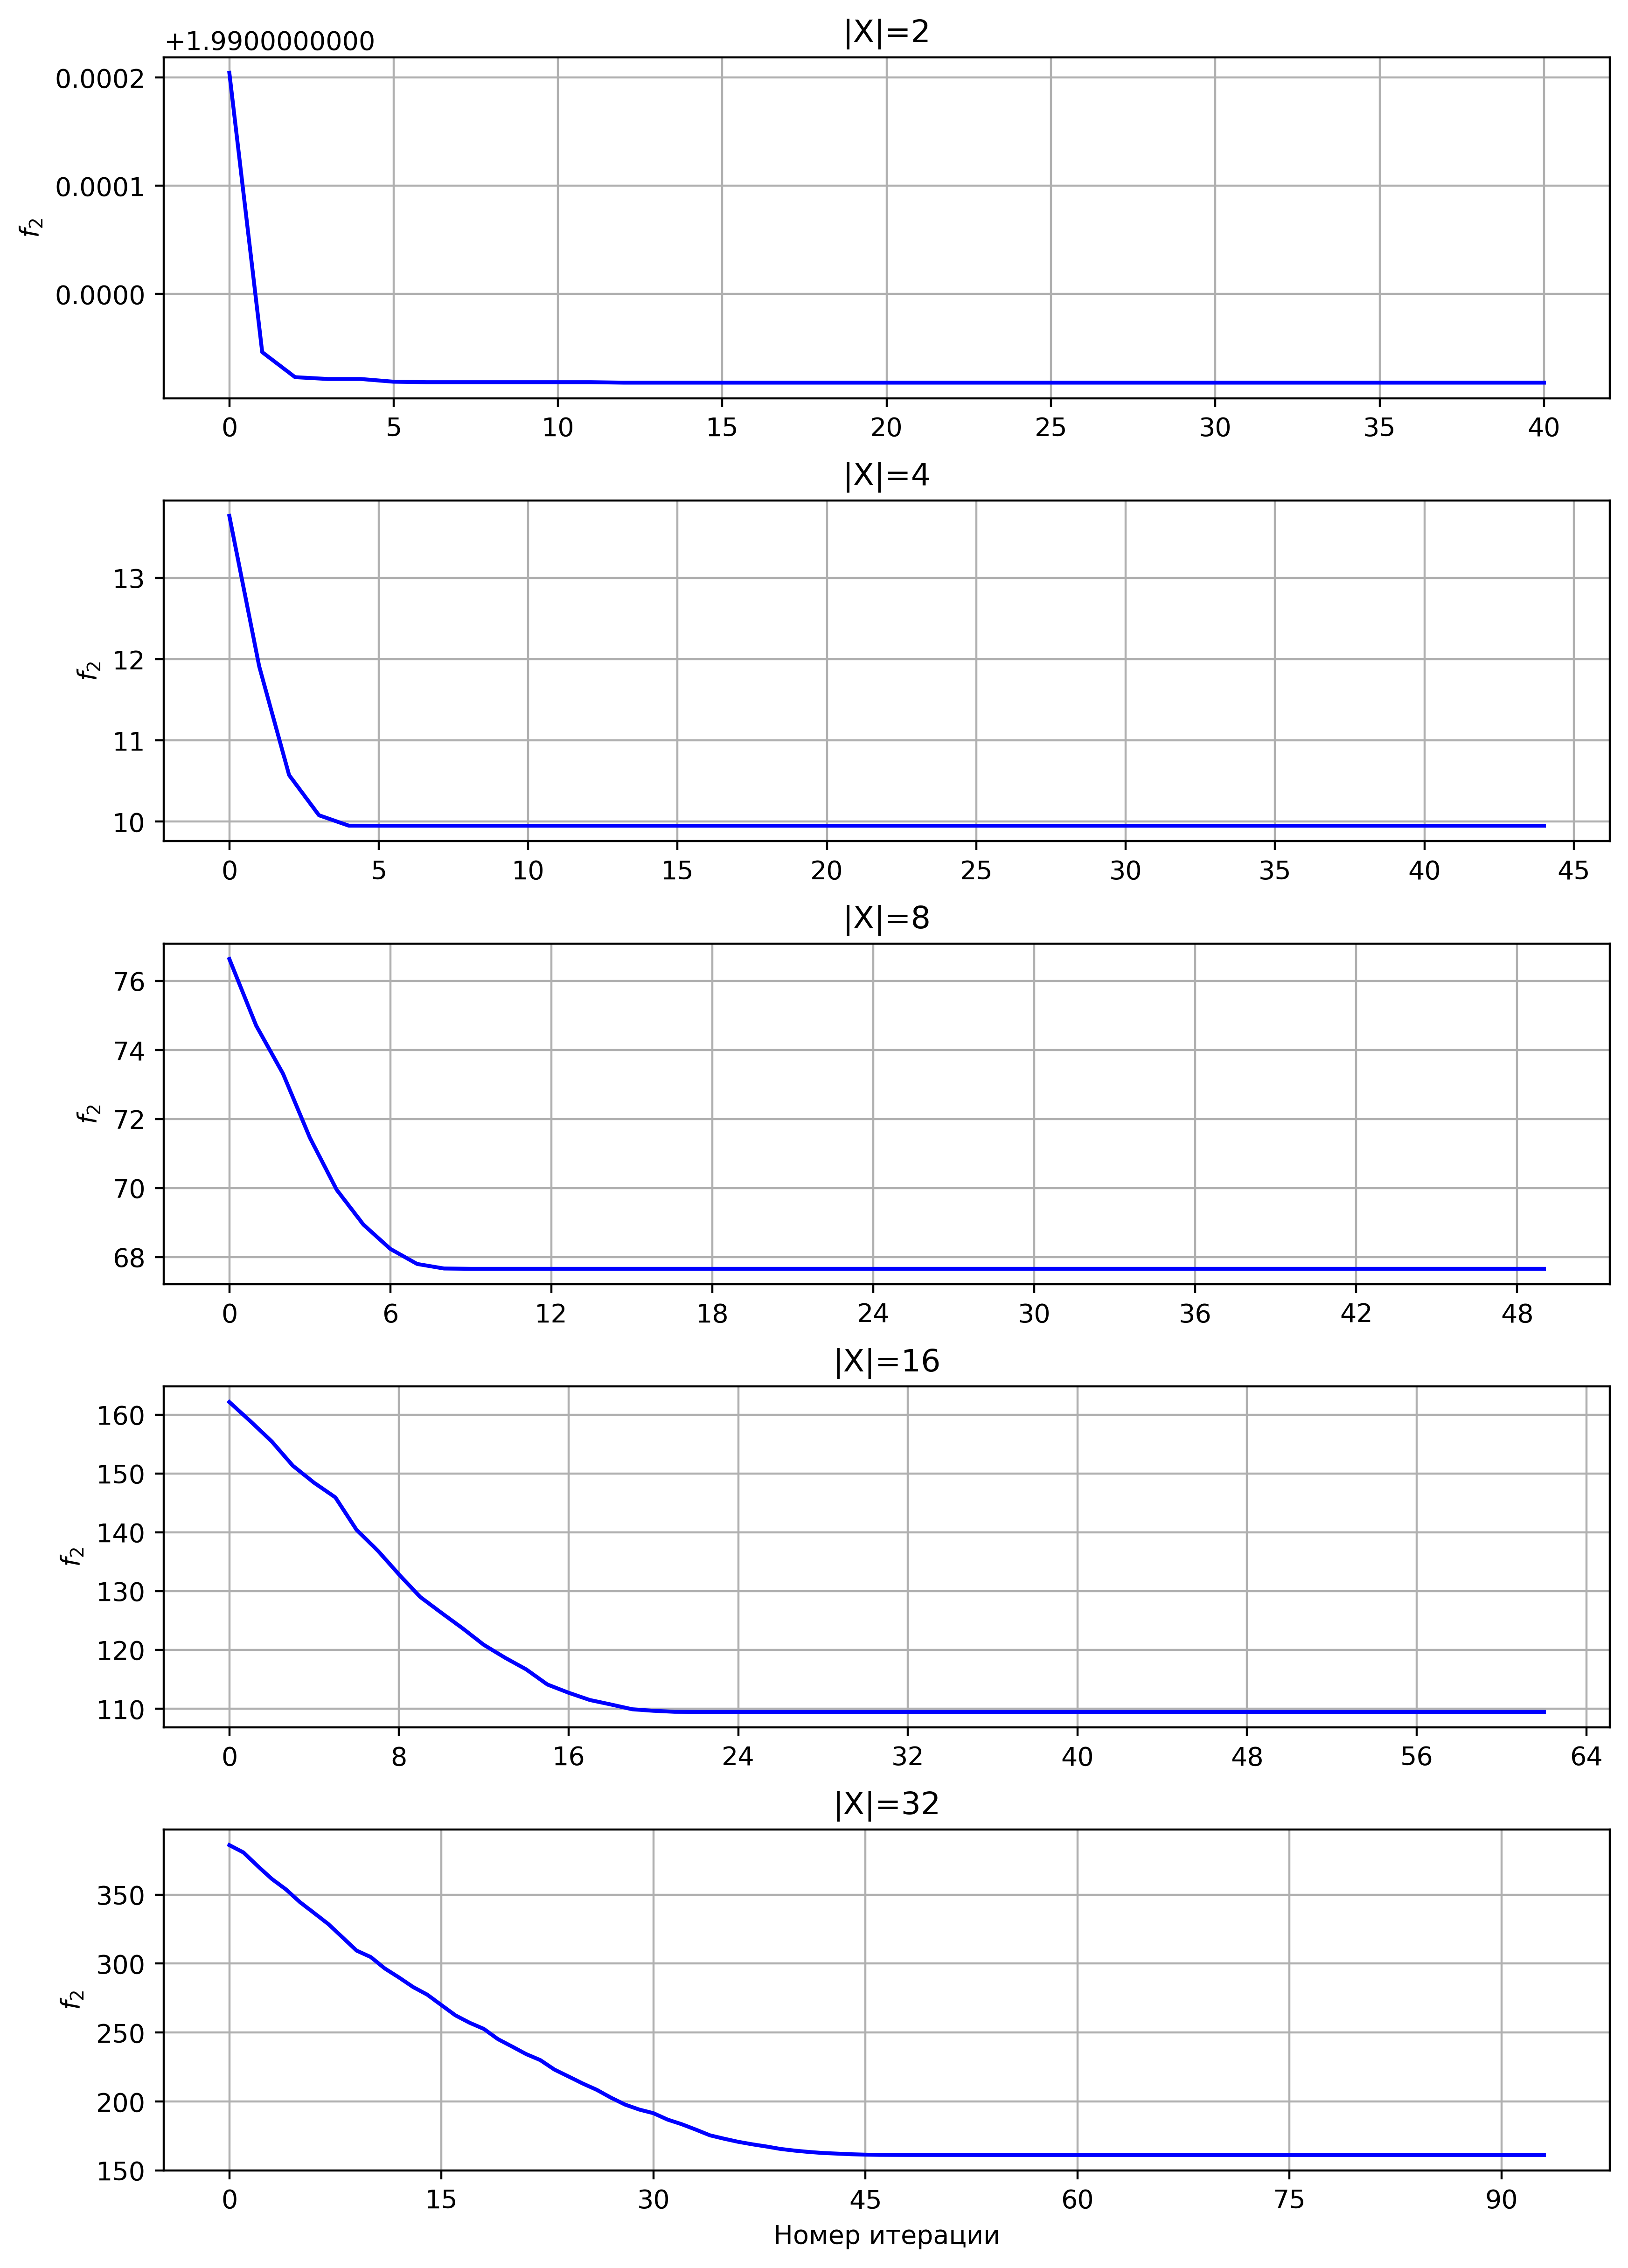

In [28]:
iter_graph(hist_Rastrigin,2)

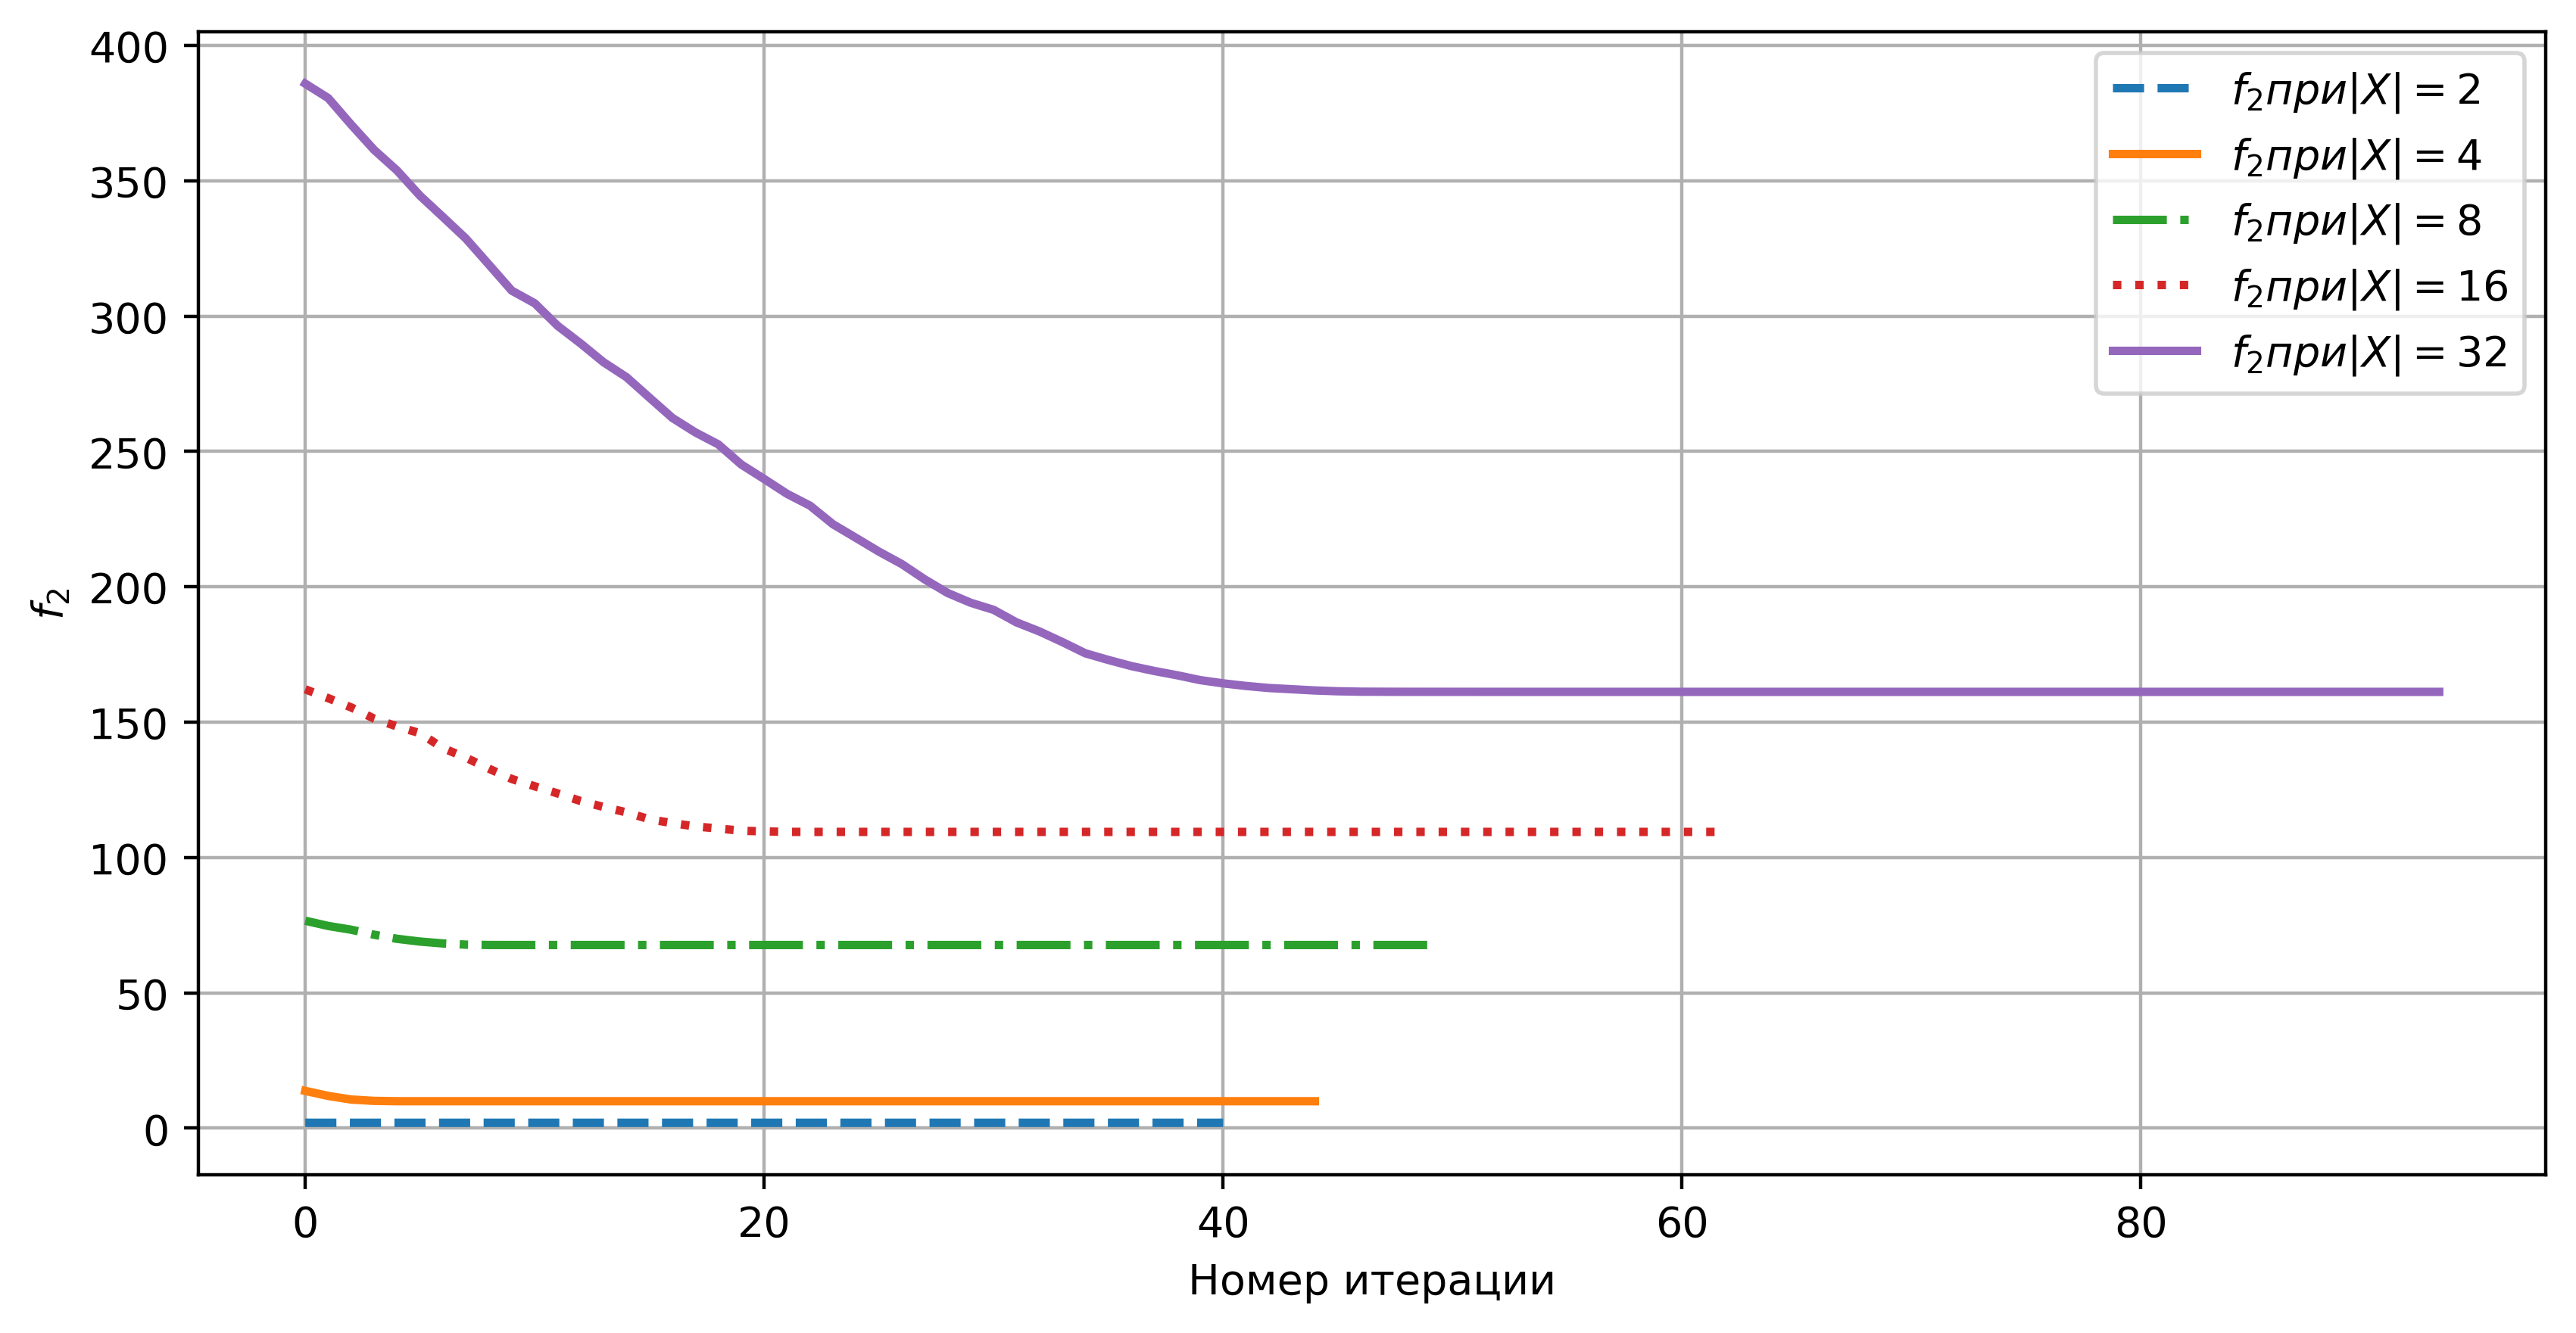

In [29]:
iter_graph2(hist_Rastrigin,2)

Function: Rosenbrok
Dim	| best f	| best x	| mean f	| mean x	| probability
min_step= 41
2	| 1.3e-10	| 4.6e-06	| 9.5e-08	| 3.2e-04	| 1.0e+00
min_step= 57
4	| 1.3e-04	| 2.2e-02	| 1.0e+00	| 6.6e-01	| 7.1e-01
min_step= 203
8	| 1.8e-02	| 2.5e-01	| 1.0e+00	| 7.9e-01	| 0.0e+00
min_step= 505
16	| 5.0e-02	| 4.1e-01	| 1.9e+00	| 1.1e+00	| 0.0e+00
min_step= 580
32	| 7.3e-01	| 1.2e+00	| 2.1e+01	| 4.2e+00	| 0.0e+00


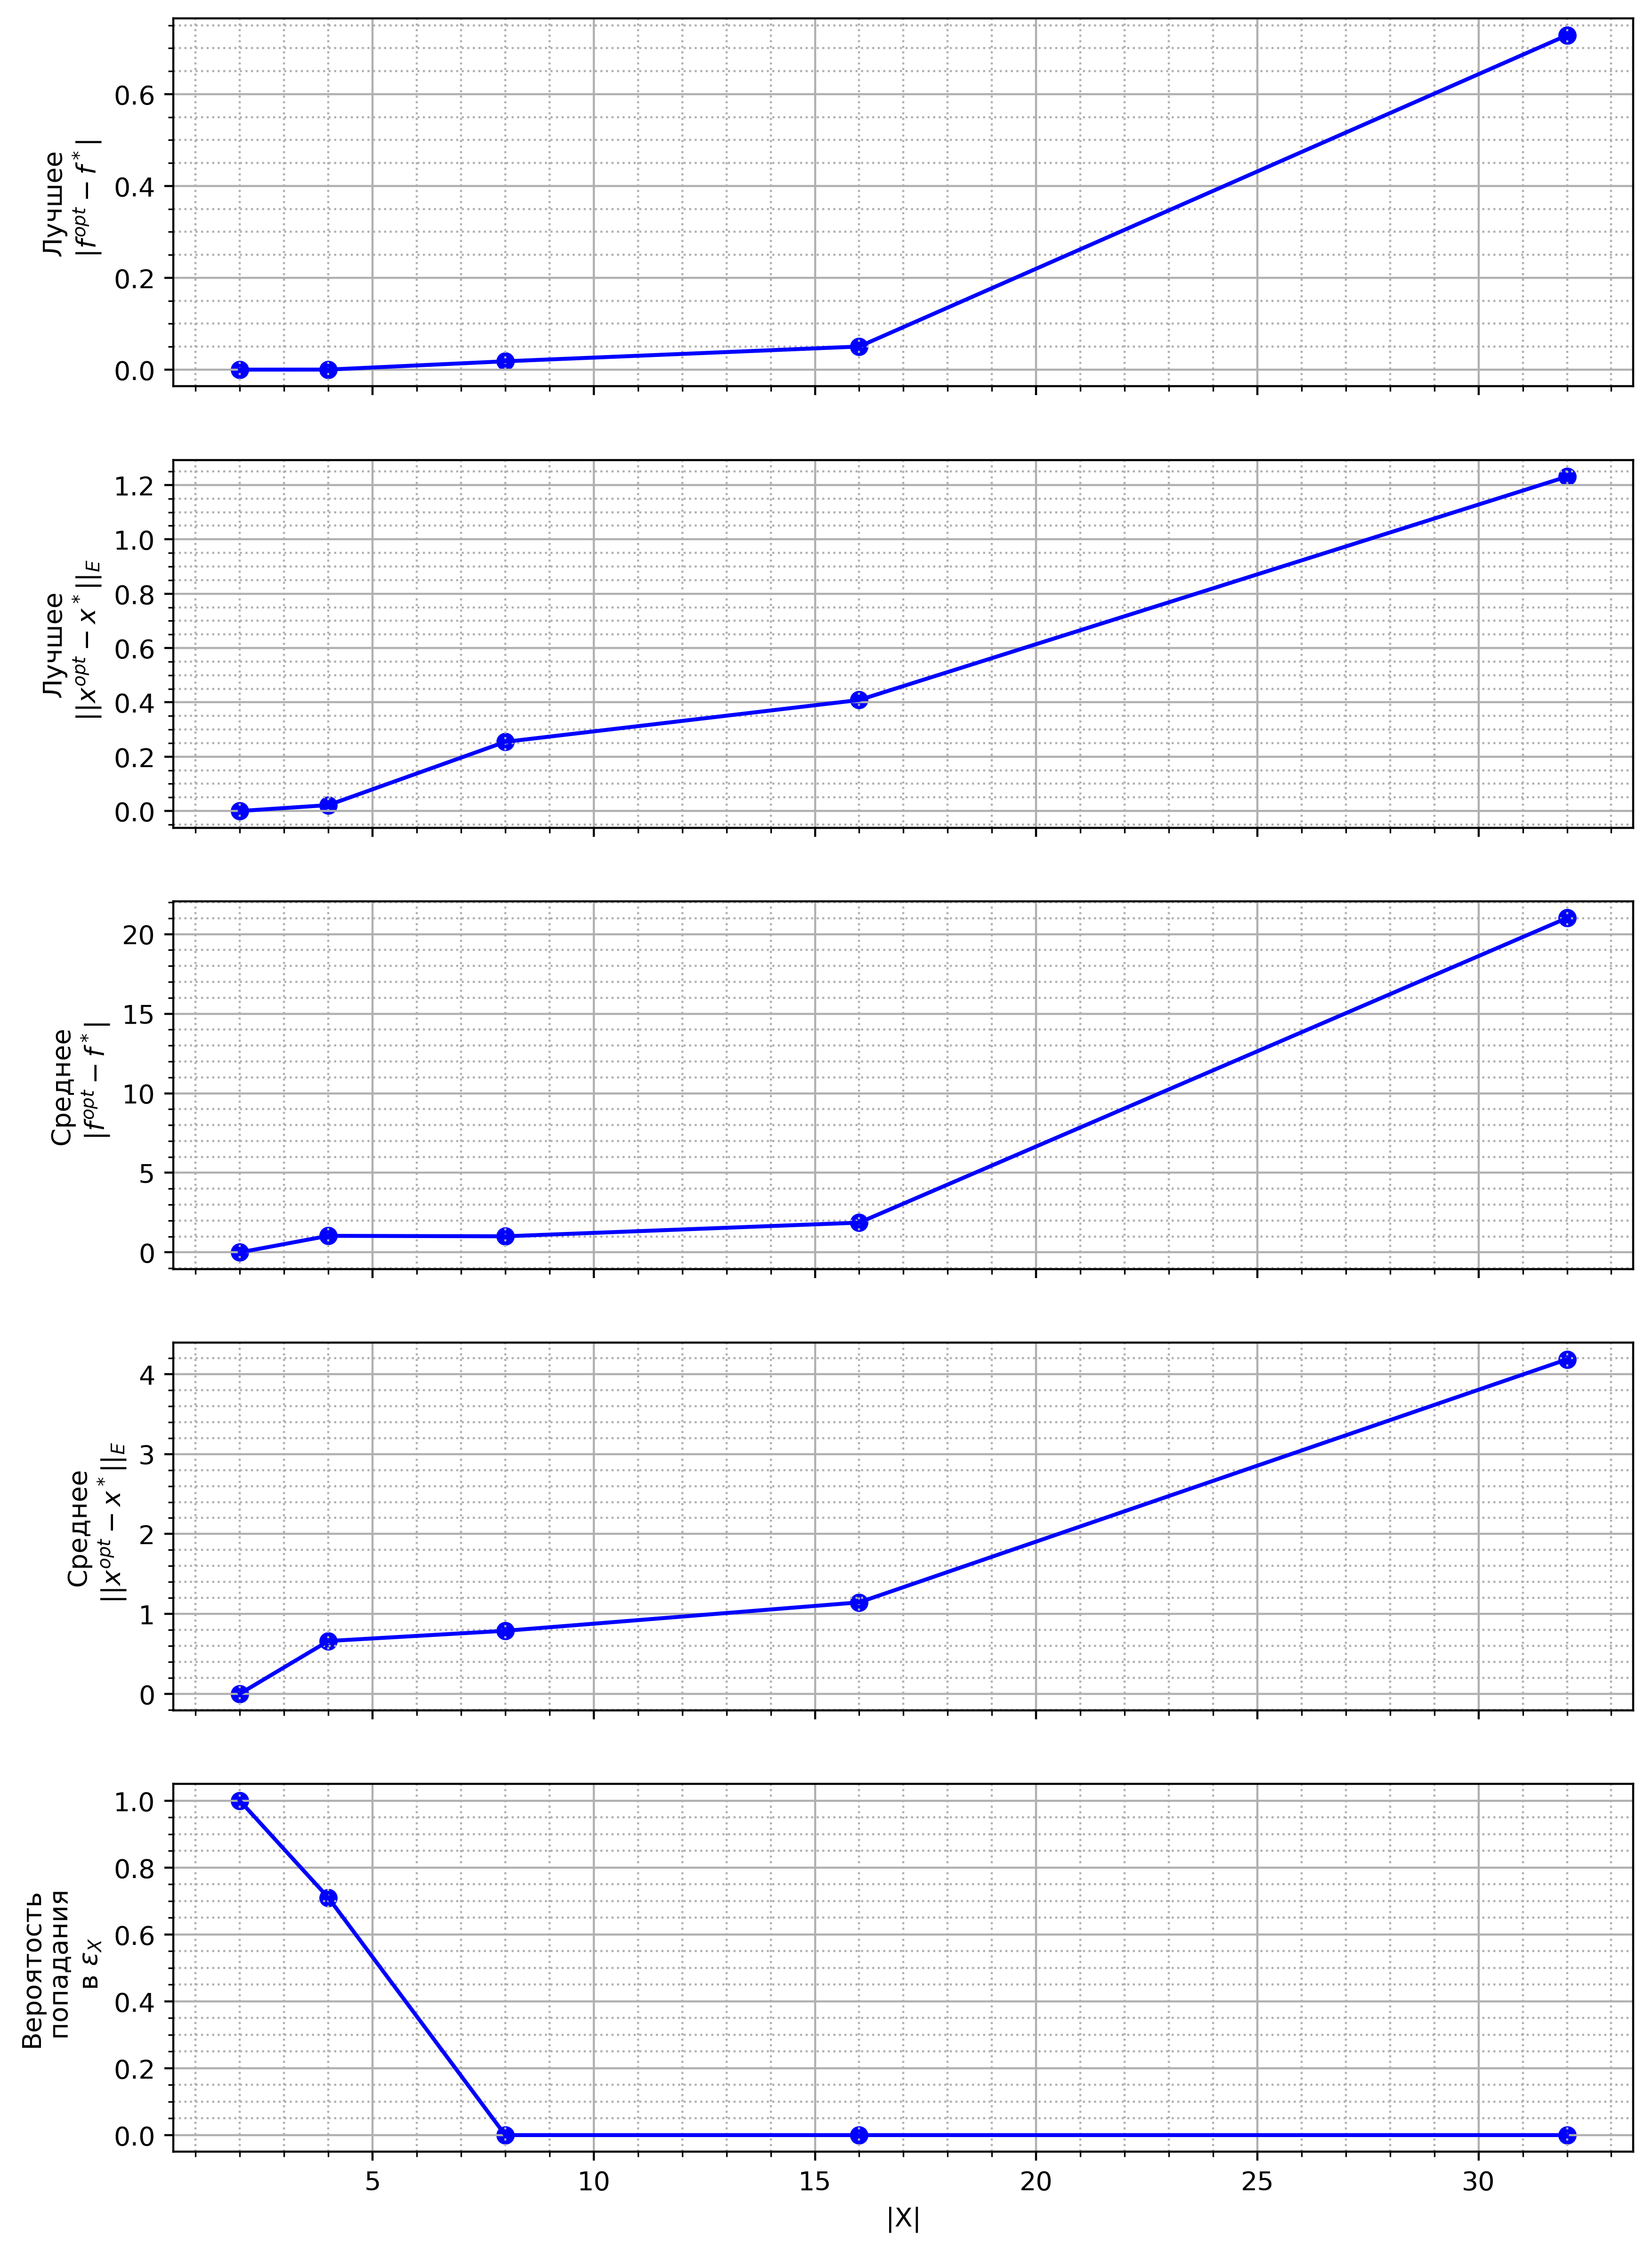

In [34]:
hist_Rosenbrok=results2(Rosenbrok)

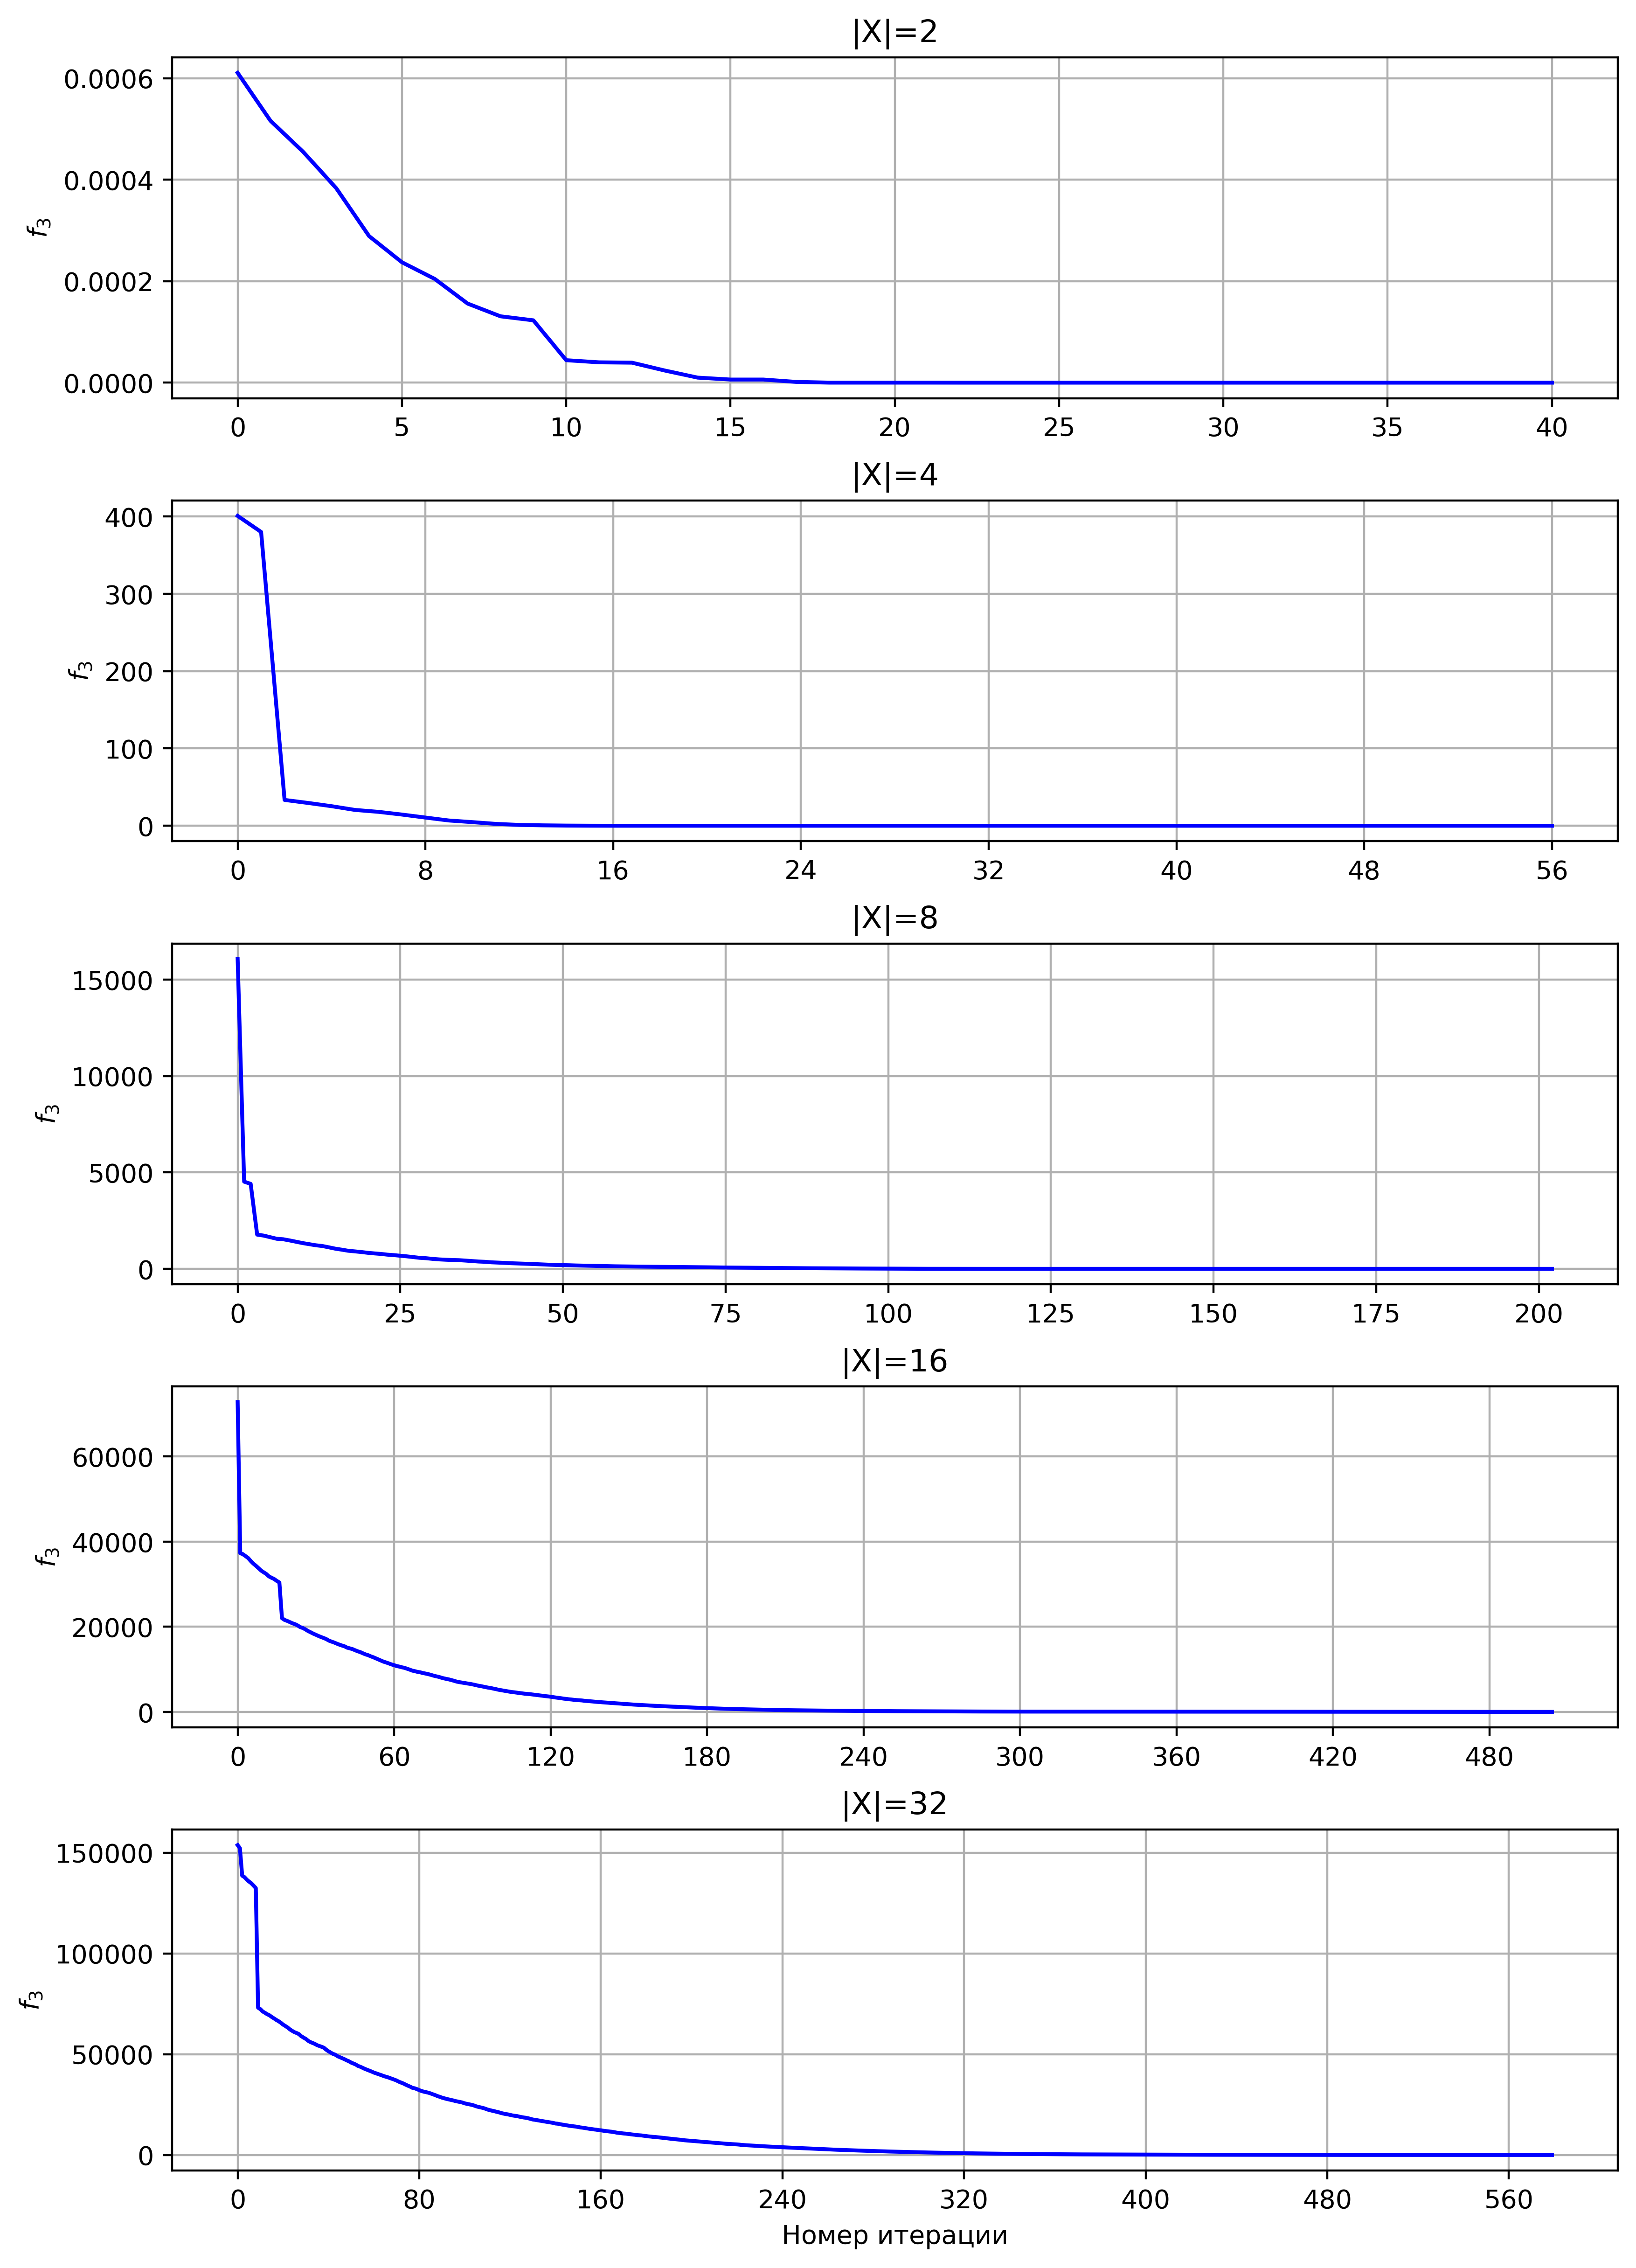

In [35]:
iter_graph(hist_Rosenbrok,3)

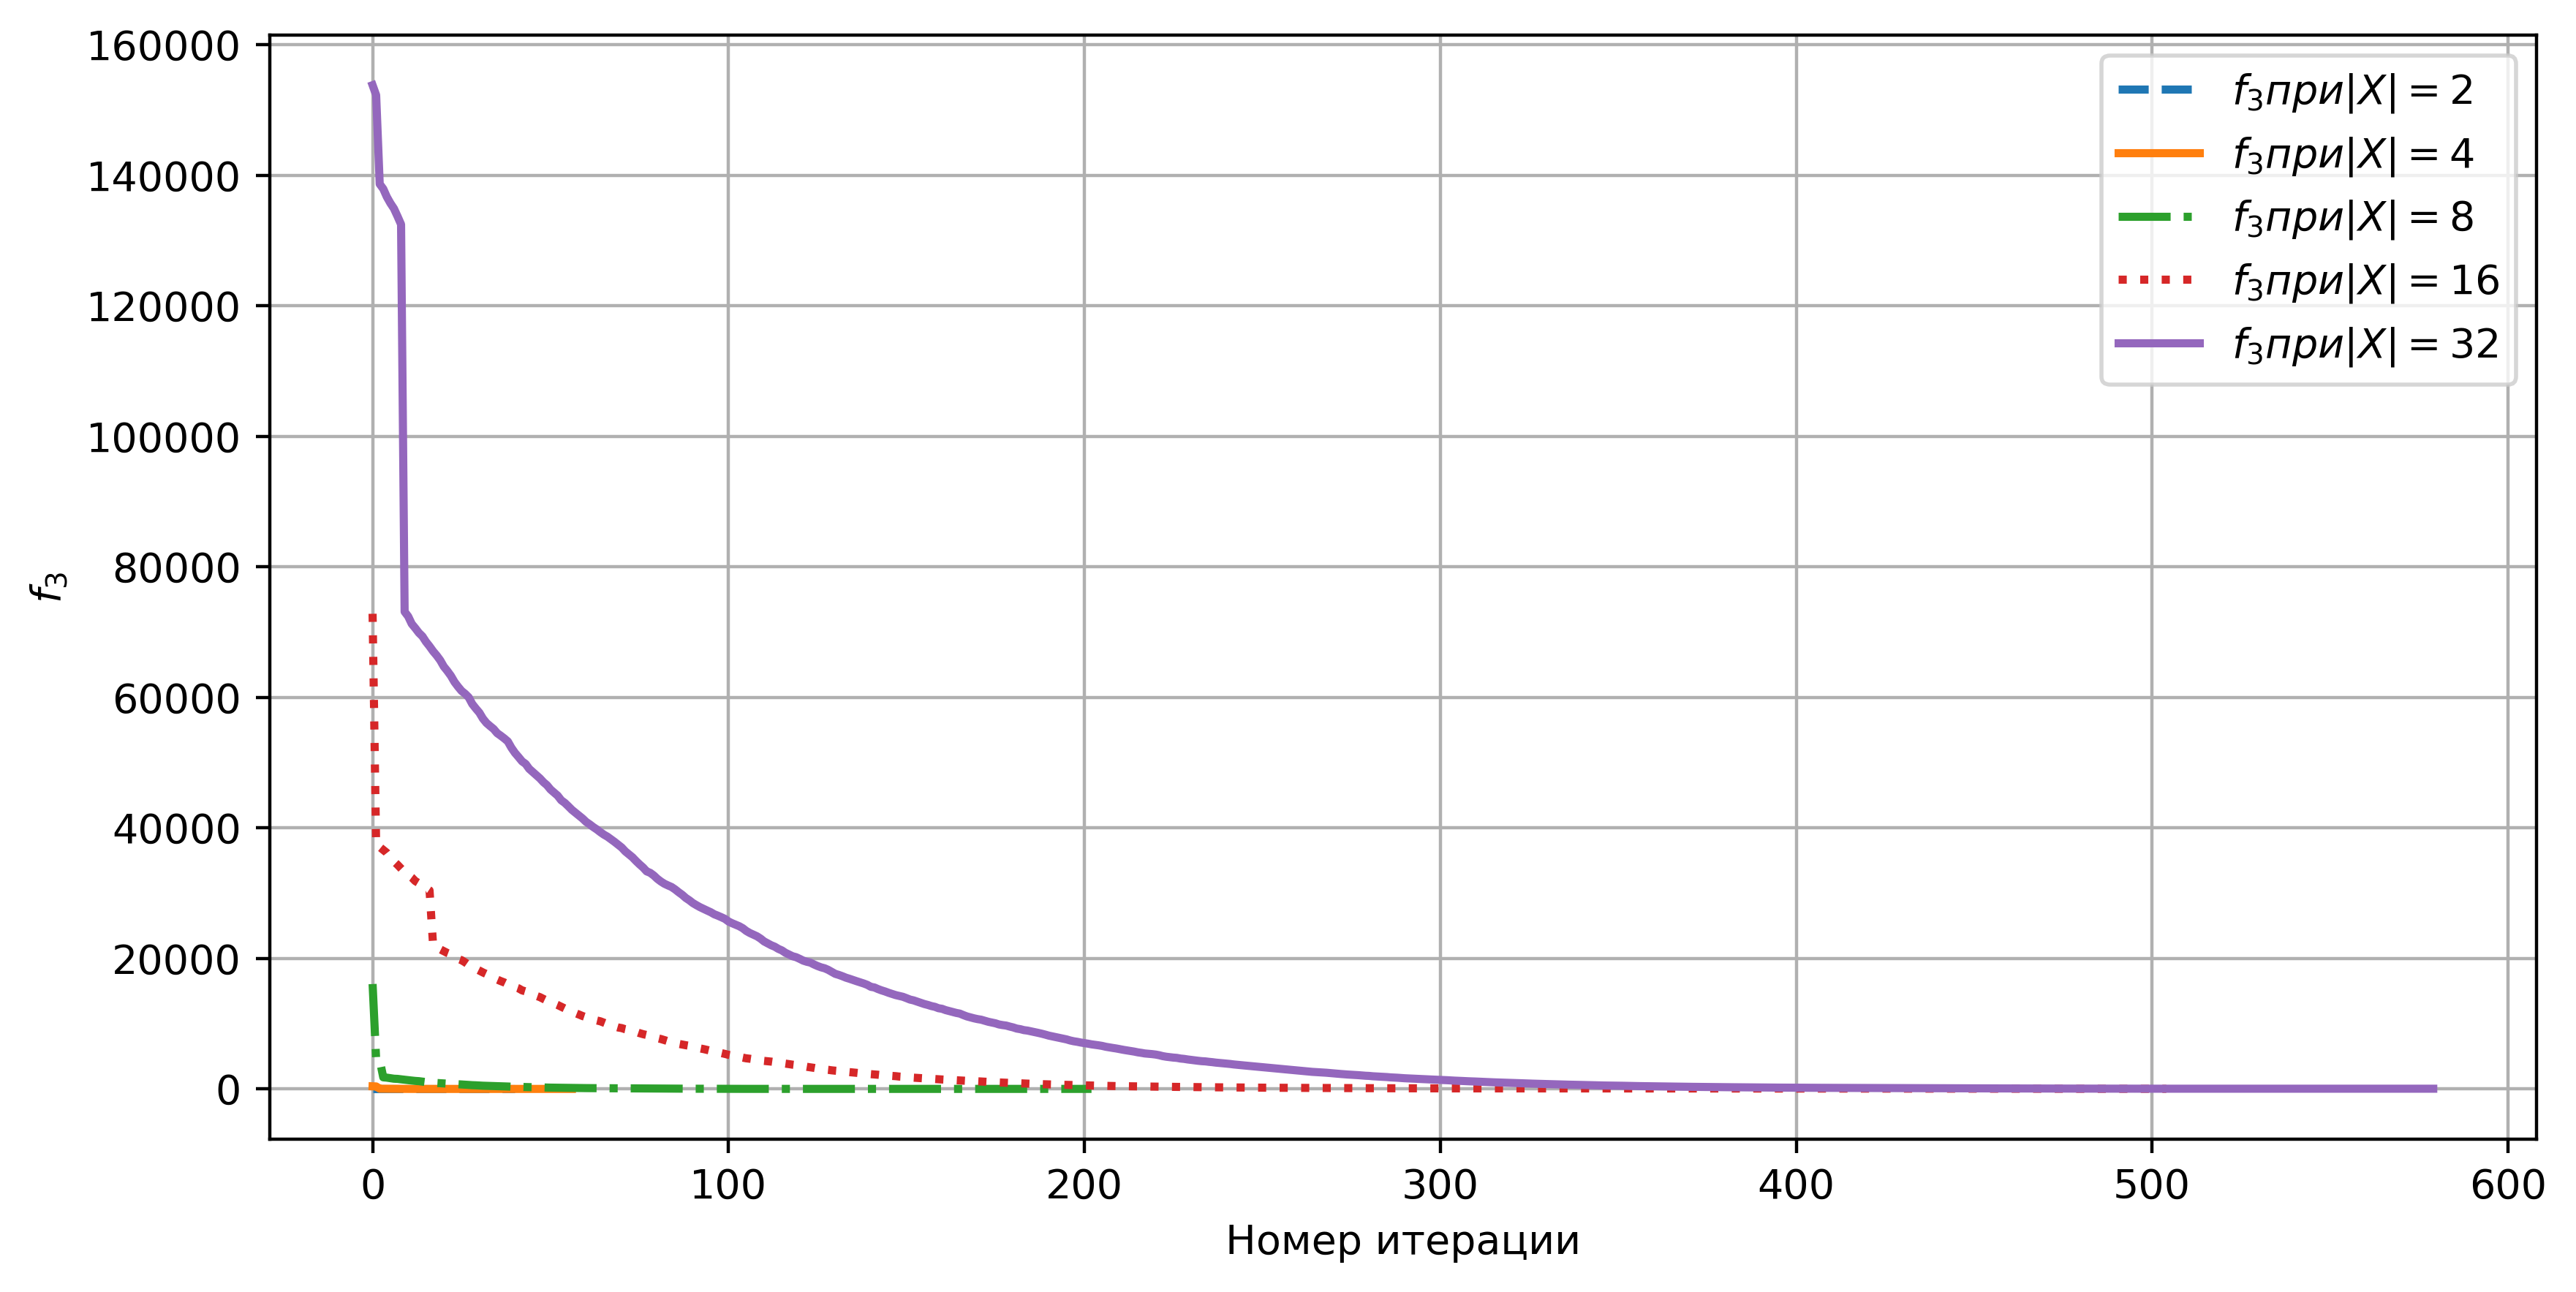

In [36]:
iter_graph2(hist_Rosenbrok,3)